# Project Steps :
The steps of the project are the following and below are the pipeline stages : 
 1. Compute the camera calibration matrix and distortion coefficients based on provided chessboard images.
 2. Undistort the Image.
 3. Create Thresholded binary image by applying color transform and gradient
 4. Apply perspective transform to get birds-eye view   
 5. Detect Lane pixels in the warped viewd
 6. Calculate the curvature of lanes and offset from center of lane
 7. Unwarp the lane markings back to original domain
 8. Superimpose the lane markings int he original image and apply these on a video frame by frame
 
 

Steps : Compute the camera calibration matrix and distortion coefficients given a set of chessboard images and undistort the image.
  
  a. Open CV function calibrateCamera is used to find the camera matrix to calibrate the camera
  
  b. The chess board images in camera_cal folder is used for calibration (9x6 points)
 

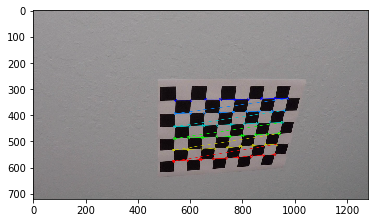

In [27]:


import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Initialise image and object point arrays
objpoints = []  # this is the 3d domain pts
imgpoints = []  # this the distorted points in 2d domain

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


#Read Camera calibration images
images = glob.glob("camera_cal/calibration*.jpg")

for fname in images :
 img = cv2.imread(fname)
 #plt.imshow(img)
 # Convert to grayscale
 gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

 # Find the chessboard corners
 ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
 #print(ret)
 # If found, draw corners
 if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [5]:
import pickle
#calibrate camera and save camera matrix as pickle file
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
cam_pickle = {}
cam_pickle["mtx"] = mtx
cam_pickle["dist"] = dist
pickle.dump( cam_pickle, open( "camera_matrix.p", "wb" ) )


Here are the original image and undistored images of chess board after applying camera calibraion.

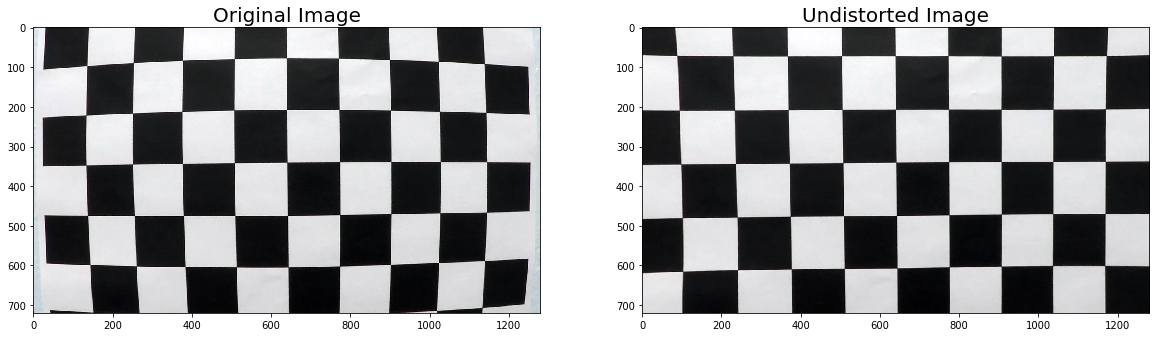

In [26]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points

out = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/orig_calibration1.jpg',img)
cv2.imwrite('output_images/undist_calibration1.jpg',out)

f, (im1, im2) = plt.subplots(1, 2, figsize=(20,10))
im1.imshow(img)
im1.set_title('Original Image', fontsize=20)
im2.imshow(out)
im2.set_title('Undistorted Image', fontsize=20)

# Start of Image Pipeline :
1. Read Image
2. Undistort the image using the camera matrix calculated above
3. Apply gradient and color transformation to capture the Lane markings
4. Apply Perspective Traform


Read Image and apply distortion correction
Below are sample images from test_images before and after undistortion.

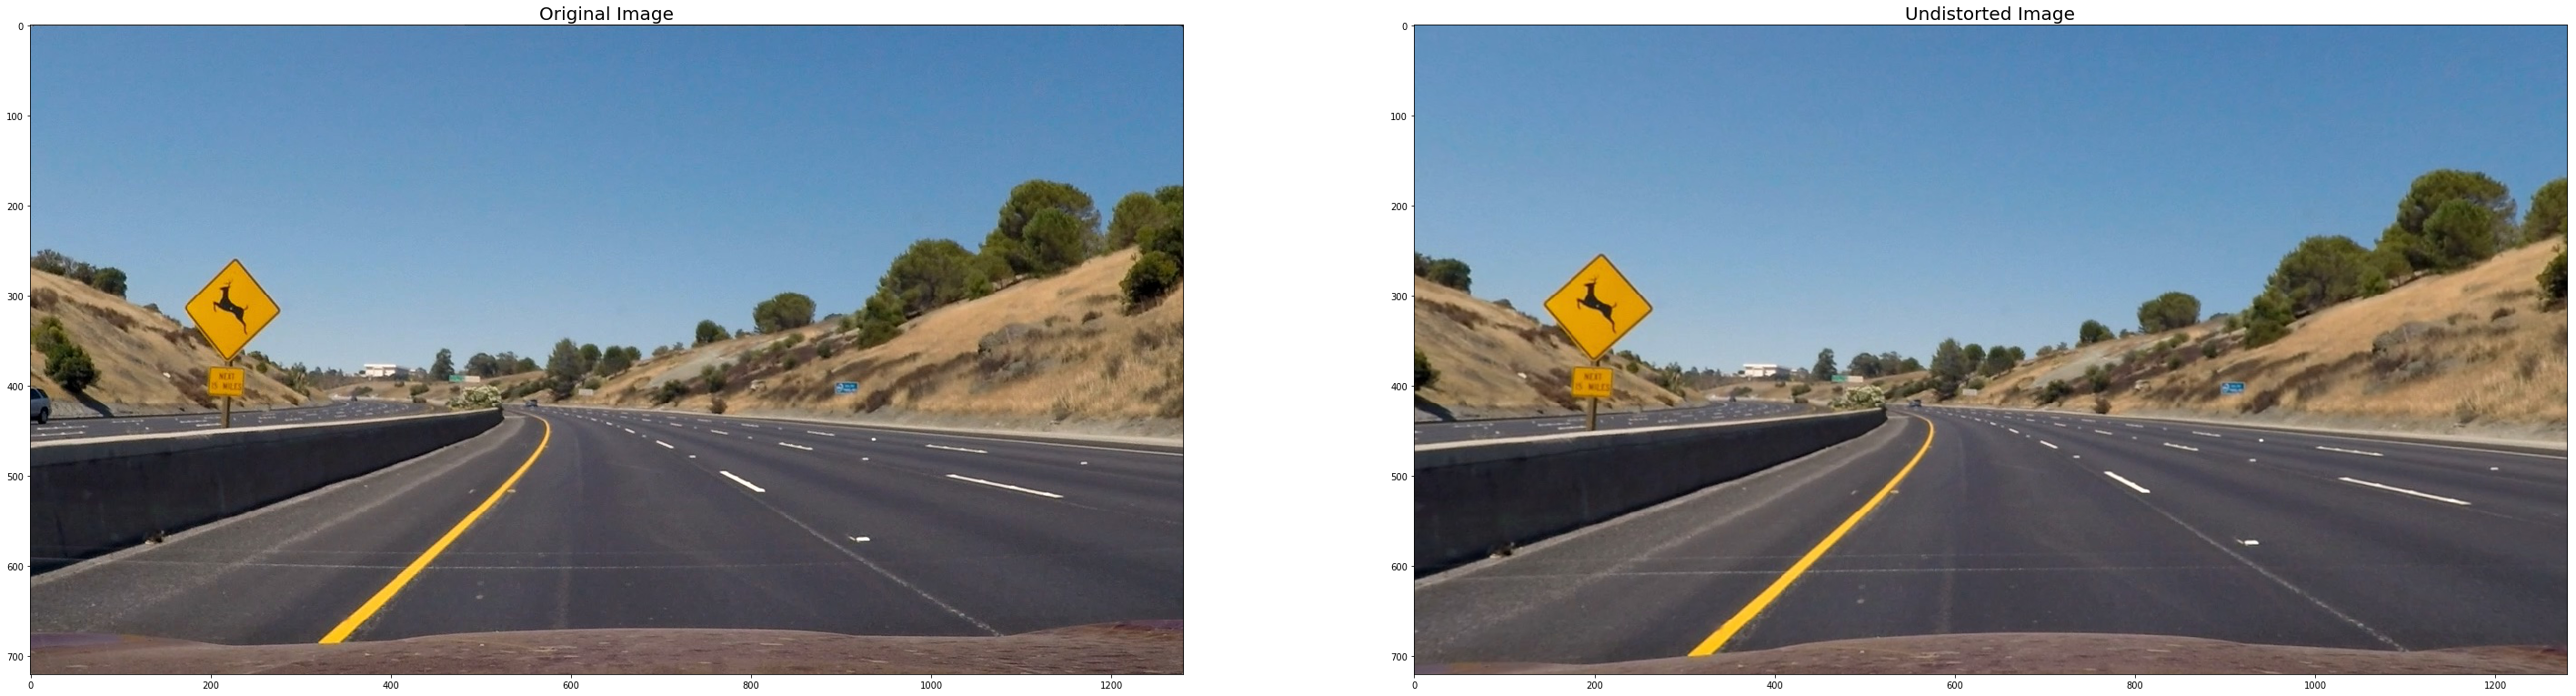

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline


with open("camera_matrix.p", mode='rb') as f:
    cam_pickle = pickle.load(f)
mtx = cam_pickle["mtx"]
dist = cam_pickle["dist"]


read_img = cv2.imread("test_images/test2.jpg")
#read_image = mpimg.imread("test_images/test1.jpg")
#since opencv reads image in bgr format
image_corr=cv2.cvtColor(read_img,cv2.COLOR_BGR2RGB)

undistorted_input = cv2.undistort(image_corr, mtx, dist, None, mtx)
cv2.imwrite('output_images/undist_test1.jpg',undistorted_input)
imshape = image_corr.shape
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(50,50))
ax1.imshow(image_corr)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_input)
ax2.set_title('Undistorted Image', fontsize=20)

Apply Gradients, thresholding and Color Transforms (S-Domain) for Binary Image. See transform_pipeline function to see how these are applied.

True

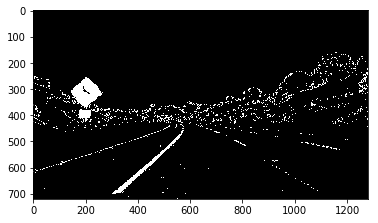

In [25]:
from primitives import *
sx_thresh = (30,100)
s_thresh =(160,255)

combined_binary = transform_pipeline(undistorted_input, s_thresh, sx_thresh )
plt.imshow(combined_binary, cmap="gray")
cv2.imwrite('output_images/grad_test1.jpg',combined_binary)


Below is the image with only the region of interest

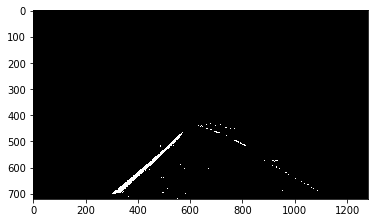

In [9]:
vertices = np.array([[(0,imshape[0]),(650, 430), (730, 430), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

Calculate the perspective tranform factors. The src and dst vectors were obtained by manually reviewing the test images provided. Below is the image with perspective transform applied on the above binary image.

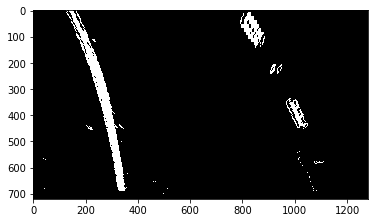

In [18]:

src = np.float32(
    [[300, 680],
     [600, 460],
     [730, 460],
     [1080, 680]])

dst = np.float32(
    [[300,680],
     [300,0],
     [1000,0],
     [1080,680]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped_img = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped_img, cmap="gray")
cv2.imwrite('output_images/warped_img_test1.jpg',warped_img)


import numpy as np
#histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
#plt.plot(histogram)


Fit curves for lane markings based on the warped binary image from above. This is the same pipeline used in class.

[640 640 640 ...,  79  79  79]
[ -2.62065907e-04   4.53339222e-01   1.47983515e+02]
[ -3.55459869e-04   6.77930305e-01   7.92840833e+02]


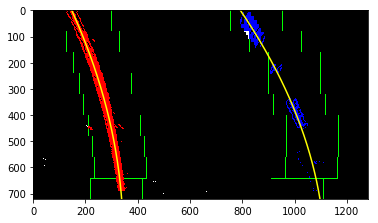

In [28]:

 
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def find_lane(binary_warped, draw=True):
    
 histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
 # Create an output image to draw on and  visualize the result
 out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
 # Find the peak of the left and right halves of the histogram
 # These will be the starting point for the left and right lines
 midpoint = np.int(histogram.shape[0]/2)
 leftx_base = np.argmax(histogram[:midpoint])
 rightx_base = np.argmax(histogram[midpoint:]) + midpoint

 # Choose the number of sliding windows
 nwindows = 9
 # Set height of windows
 window_height = np.int(binary_warped.shape[0]/nwindows)
 # Identify the x and y positions of all nonzero pixels in the image
 nonzero = binary_warped.nonzero()
 nonzeroy = np.array(nonzero[0])
 nonzerox = np.array(nonzero[1])
 # Current positions to be updated for each window
 leftx_current = leftx_base
 rightx_current = rightx_base
 # Set the width of the windows +/- margin
 margin = 100
 # Set minimum number of pixels found to recenter window
 minpix = 50
 # Create empty lists to receive left and right lane pixel indices
 left_lane_inds = []
 right_lane_inds = []

# Step through the windows one by one
 for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

 # Concatenate the arrays of indices
 left_lane_inds = np.concatenate(left_lane_inds)
 right_lane_inds = np.concatenate(right_lane_inds)

 # Extract left and right line pixel positions
 leftx = nonzerox[left_lane_inds]
 lefty = nonzeroy[left_lane_inds] 
 rightx = nonzerox[right_lane_inds]
 righty = nonzeroy[right_lane_inds] 

 # Fit a second order polynomial to each
 left_fit = np.polyfit(lefty, leftx, 2)
 right_fit = np.polyfit(righty, rightx, 2)
 
 
 ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
 left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
 right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

 out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
 out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
 if(draw) :   
  plt.imshow(out_img)
  plt.plot(left_fitx, ploty, color='yellow')
  plt.plot(right_fitx, ploty, color='yellow')
  plt.xlim(0, 1280)
  plt.ylim(720, 0)
  cv2.imwrite('output_images/lane_markings_test1.jpg',out_img)

 return leftx, lefty, rightx, righty, left_fit , right_fit, out_img , ploty, left_fitx, right_fitx


binary_warped = np.zeros_like(warped_img[:,:])
binary_warped[(warped_img[:,:] > 0)] = 1

leftx, lefty, rightx, righty, left_fit , right_fit , lane_img , ploty, left_fitx, right_fitx = find_lane(binary_warped)

print(righty)
print(left_fit)
print(right_fit)


Define Functions for calculating curvature and offset. The radius of curvature is transformed from the pixel based y_to_fit and x_to_fit params to meters and a new polynomal is fit for this. The road curvature is assumed to be circular.

For the position of the vehicle, the camera is assumed to be mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the output offset. It is assumed that lane_width is 3.7m and pixel wise x and y values are converted to meter scale.

Below is the image with Unwarped lane markings in the orignal image along with curvature and lane offset statistics embedded.

In [13]:

def calc_curvature(y_to_fit, x_to_fit, y_eval):
    # Conversion factors for pixels to meters
    m_per_pix_y, m_per_pix_x = 30/720, 3.7/700 # taken from class
    
    # Fit a new polynomial to world-space (in meters)
    fit = np.polyfit(y_to_fit*m_per_pix_y, x_to_fit*m_per_pix_x, 2)
    curvature = ((1 + (2*fit[0]*(y_eval*m_per_pix_y) + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return curvature


def calc_offset(left_x, right_x, img_center_x):
    lane_width = abs(left_x - right_x)
    lane_center_x = (left_x + right_x)//2
    pix_offset = img_center_x - lane_center_x
    lane_width_m = 3.7  
    return lane_width_m * (pix_offset/lane_width)
        
left_curv =  calc_curvature(lefty, leftx, np.max(ploty))
right_curv  =  calc_curvature(righty, rightx, np.max(ploty))  
print(left_curv)
print(right_curv)
offset = calc_offset(left_fitx[-1], right_fitx[-1], binary_warped.shape[1]//2)
print(offset)


626.750431532
462.32225106
-0.375829124117


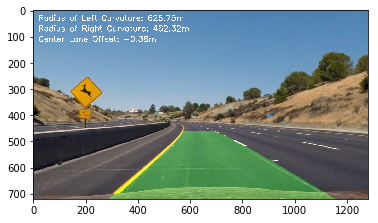

In [20]:
#Overlap orig image with lane polygon
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_input.shape[1], undistorted_input.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_input, 1, newwarp, 0.3, 0)
cv2.imwrite('output_images/final_lane_polygon_test1.jpg',result)

cv2.putText(result,'Radius of Left Curvature: %.2fm' % left_curv,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
cv2.putText(result,'Radius of Right Curvature: %.2fm' % right_curv,(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
cv2.putText(result,'Center Lane Offset: %.2fm' % offset,(20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
plt.imshow(result)

Consolidate the entire image pipeline described above to a single function to be used for video processing.
Additional metrics added : We save the previous frame's lane markings and maintain the lane markings from previous frame if the radius of curvature is predicted to be below a threshold of 460 m and the offset is less than -1.5 or greater than 1.5 m. This is to prevent cases where the pipeline predicts certain lane markings to be wrong due to shadows or changes in road texture, and this transform seems to fit well for the test video.

626.750431532
462.32225106
-0.375829124117


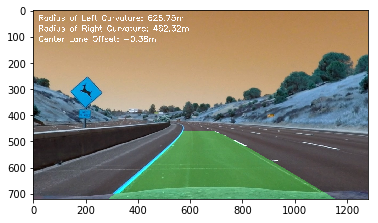

In [21]:
## Full Image pipeline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline


with open("camera_matrix.p", mode='rb') as f:
    cam_pickle = pickle.load(f)
mtx = cam_pickle["mtx"]
dist = cam_pickle["dist"]


def keep_last_fit(left_curve, right_curve,offset):
    if right_curve < 460 or left_curve <  460 or offset > 1.5 or offset < -1.5:
        return False
    else:
        return True


last_left_fit = None
last_right_fit = None
last_left_fitx = None
last_right_fitx = None
last_ploty = None

def image_pipeline(input_file, filepath=False):
 global last_left_fit
 global last_right_fit
 global last_left_fitx
 global last_right_fitx
 global last_ploty
    
 plt.clf()
   
 if filepath == True:
        # Read in image
        read_img = cv2.imread(input_file)
 else:
        read_img = input_file

 #image_corr=cv2.cvtColor(read_img,cv2.COLOR_BGR2BGR)
 
 undistorted_input = cv2.undistort(read_img, mtx, dist, None, mtx)
 imshape = image_corr.shape

#### Edge Detection
 sx_thresh = (30,100)
 s_thresh =(160,255)
 combined_binary = transform_pipeline(undistorted_input, s_thresh, sx_thresh )
######## Apply perspective transform
 src = np.float32(
    [[300, 680],
     [600, 460],
     [730, 460],
     [1080, 680]])

 dst = np.float32(
    [[300,680],
     [300,0],
     [1000,0],
     [1080,680]])

 M = cv2.getPerspectiveTransform(src, dst)
 Minv = cv2.getPerspectiveTransform(dst, src)
 warped_img = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
####### find lane     
 binary_warped = np.zeros_like(warped_img[:,:])
 binary_warped[(warped_img[:,:] > 0)] = 1

 leftx, lefty, rightx, righty, left_fit , right_fit , lane_img , ploty, left_fitx, right_fitx = find_lane(binary_warped,False)

###### calc curvatur and curv
 left_curv =  calc_curvature(lefty, leftx, np.max(ploty))
 right_curv  =  calc_curvature(righty, rightx, np.max(ploty))  
 print(left_curv)
 print(right_curv)
 offset = calc_offset(left_fitx[-1], right_fitx[-1], binary_warped.shape[1]//2)
 print(offset)
 
 if(keep_last_fit(left_curv,right_curv,offset)) :
    last_left_fitx = left_fitx
    last_right_fitx = right_fitx
    last_ploty = ploty 
 else :
    left_fitx = last_left_fitx
    right_fitx = last_right_fitx
    ploty = last_ploty  
#Overlap orig image with lane polygon
 warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
 color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

 pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
 pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
 pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
 cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
 newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_input.shape[1], undistorted_input.shape[0])) 

# Combine the result with the original image
 result = cv2.addWeighted(undistorted_input, 1, newwarp, 0.3, 0)

 cv2.putText(result,'Radius of Left Curvature: %.2fm' % left_curv,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
 cv2.putText(result,'Radius of Right Curvature: %.2fm' % right_curv,(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
 cv2.putText(result,'Center Lane Offset: %.2fm' % offset,(20,120), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
 plt.imshow(result)
 cv2.imwrite('output_images/final_lane_markings_all_pipe_test1.jpg',result)   
    
 return result

combined_img = image_pipeline(read_img)

  

Test the pipeline on video

631.838900051
784.314152026
-0.429192560058
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

631.838900051
784.314152026
-0.429192560058


  0%|          | 1/1261 [00:00<03:46,  5.56it/s]

623.658732455
833.093264398
-0.43318939227


  0%|          | 2/1261 [00:00<03:46,  5.57it/s]

543.002332432
520.79736079
-0.407838674742


  0%|          | 3/1261 [00:00<03:41,  5.69it/s]

518.739287291
541.402776565
-0.41517053733


  0%|          | 4/1261 [00:00<03:37,  5.77it/s]

530.54331396
613.658383399
-0.434687430851


  0%|          | 5/1261 [00:00<03:35,  5.82it/s]

563.558904092
673.403030841
-0.445340740238


  1%|          | 8/1261 [00:01<03:44,  5.58it/s]

590.399586368
818.39742691
-0.465160410584
599.079913405
2404.12440768
-0.503171832699


  1%|          | 9/1261 [00:01<03:40,  5.67it/s]

616.941939405
4442.68600532
-0.508683486282
619.278519693
3087.95955467
-0.505682745801


  1%|          | 12/1261 [00:02<03:13,  6.47it/s]

629.008639302
1205.15722103
-0.479838513834
689.466539707
1746.23189074
-0.490012121051


  1%|          | 13/1261 [00:02<03:27,  6.02it/s]

705.906888658
1124.6217918
-0.478490848673
743.320610617
1769.92533341
-0.488394206616


  1%|▏         | 16/1261 [00:02<03:05,  6.71it/s]

731.682770376
883.676207552
-0.467365837092
781.703254155
608.663080404
-0.454551852505


  1%|▏         | 18/1261 [00:02<02:58,  6.95it/s]

759.100534098
858.774722206
-0.456862536726
834.823301521
930.126167935
-0.458244217132


  2%|▏         | 19/1261 [00:03<02:56,  7.06it/s]

900.954055878
944.040259759
-0.457593652753
936.982068437
1010.66203091
-0.44960476895


  2%|▏         | 22/1261 [00:03<02:57,  6.97it/s]

1024.99061188
1150.30660416
-0.4566778167
1202.2723269
1099.69374917
-0.447565710445


  2%|▏         | 23/1261 [00:03<02:57,  6.98it/s]

1220.77679188
1098.76244765
-0.433473363442
1038.15951896
1068.89875466
-0.425256313242


  2%|▏         | 25/1261 [00:03<03:01,  6.81it/s]

1005.09381952
655.647988922
-0.39637592849
958.371290926
635.670813555
-0.385893454822


  2%|▏         | 28/1261 [00:04<02:53,  7.10it/s]

900.824767569
969.53126416
-0.396656362412
931.717311921
956.795784687
-0.384861608315


  2%|▏         | 30/1261 [00:04<02:49,  7.27it/s]

842.045488121
793.555937488
-0.375927172502
748.943460364
588.793315863
-0.367972766961


  3%|▎         | 32/1261 [00:04<02:54,  7.05it/s]

673.426599192
734.011650133
-0.375264501105
619.860896962
654.189655343
-0.371559124405


  3%|▎         | 34/1261 [00:05<02:50,  7.20it/s]

629.443920025
1202.65311782
-0.41065764304
572.630291613
1639.41458315
-0.4107723719


  3%|▎         | 35/1261 [00:05<02:48,  7.27it/s]

575.517239275
1218.04798552
-0.408716991841
552.91430013
751.017704291
-0.385614773625


  3%|▎         | 38/1261 [00:05<03:07,  6.52it/s]

528.630150675
695.02272364
-0.378461641295
498.363116432
607.894839221
-0.371958737998


  3%|▎         | 40/1261 [00:06<02:55,  6.95it/s]

472.363202143
584.370207351
-0.372453730236
465.484685804
426.238658504
-0.356909900923


  3%|▎         | 41/1261 [00:06<02:53,  7.04it/s]

446.060835726
490.986914265
-0.368423994644
443.204881904
653.937573853
-0.384355690729


  3%|▎         | 44/1261 [00:06<03:03,  6.64it/s]

460.253152712
677.047892524
-0.398913897466
470.546248991
663.647380791
-0.403441155141


  4%|▎         | 46/1261 [00:07<03:01,  6.70it/s]

488.414059584
735.250532832
-0.430058147926
489.59372426
1009.96620814
-0.43316215306


  4%|▎         | 47/1261 [00:07<03:17,  6.13it/s]

528.619977835
874.847157061
-0.423497383635
519.756127945
1033.29686492
-0.435969600731


  4%|▍         | 50/1261 [00:07<03:09,  6.38it/s]

563.135798165
996.120587579
-0.437454906273
588.428768171
669.138315988
-0.420311995438


  4%|▍         | 51/1261 [00:07<03:08,  6.43it/s]

634.370474353
681.991963776
-0.426437554801
670.519037527
902.731595166
-0.438088020659


  4%|▍         | 54/1261 [00:08<03:05,  6.49it/s]

691.563715733
537.948687796
-0.416096519451
718.952269952
504.134980069
-0.411243384888


  4%|▍         | 55/1261 [00:08<03:08,  6.41it/s]

784.999311826
609.917521784
-0.423900967736


  4%|▍         | 56/1261 [00:08<03:24,  5.90it/s]

863.471748936
769.848024908
-0.427111308702
1012.48318879
635.039285385
-0.432767293696


  5%|▍         | 59/1261 [00:09<03:00,  6.68it/s]

992.155169739
1187.30808123
-0.458768871822
1000.37006701
1057.03717458
-0.43706306548


  5%|▍         | 60/1261 [00:09<02:56,  6.79it/s]

1027.1469075
777.471790697
-0.421832669223
852.485442715
1030.64157054
-0.414095063489


  5%|▍         | 63/1261 [00:09<03:21,  5.95it/s]

804.089797694
787.330948534
-0.385797025308
774.390406757
2316.12044257
-0.408356271683


  5%|▌         | 65/1261 [00:10<03:05,  6.45it/s]

748.636752243
559.965086626
-0.359063371034
696.488406203
633.884141943
-0.3470734068


  5%|▌         | 67/1261 [00:10<02:52,  6.90it/s]

666.14982922
617.246415127
-0.337079221174
650.728576849
1001.5933065
-0.344001820357


  5%|▌         | 69/1261 [00:10<02:52,  6.93it/s]

689.001862012
902.029805672
-0.339973199239
667.175560086
1009.43782329
-0.335705701318


  6%|▌         | 71/1261 [00:10<02:47,  7.12it/s]

658.870690006
2422.17598289
-0.356170929077
673.090538085
1246.92077578
-0.322707104043


  6%|▌         | 73/1261 [00:11<02:50,  6.96it/s]

743.575070423
743.759076475
-0.299713841271
796.266393562
627.677098676
-0.292457400587


  6%|▌         | 75/1261 [00:11<02:45,  7.14it/s]

859.037644353
862.156603388
-0.312981556478
994.610549743
891.401642837
-0.308416673001


  6%|▌         | 76/1261 [00:11<02:48,  7.02it/s]

1064.56347997
610.624457399
-0.294028167627
1280.6601186
993.622442143
-0.316715477198


  6%|▌         | 78/1261 [00:12<02:51,  6.89it/s]

1538.75687308
726.436000175
-0.303796274875
1674.24947492
493.495415308
-0.285625644795


  6%|▋         | 81/1261 [00:12<03:07,  6.30it/s]

1605.58324975
541.347712827
-0.283720765704
1805.83371006
666.38815334
-0.287949386962


  7%|▋         | 82/1261 [00:12<03:14,  6.08it/s]

1952.22361609
636.258171132
-0.282273608399
1709.90591321
776.72596586
-0.283319263342


  7%|▋         | 84/1261 [00:13<03:08,  6.24it/s]

1796.51560673
1079.97133284
-0.296428929629
1567.83174209
1235.12271771
-0.290491472691


  7%|▋         | 87/1261 [00:13<03:00,  6.52it/s]

1332.25340117
1434.49763889
-0.284542475213
1069.07117687
859.280405639
-0.260712440369


  7%|▋         | 88/1261 [00:13<02:56,  6.65it/s]

925.116922775
1351.69760348
-0.263306330734
782.719006329
1861.61956127
-0.266747155416


  7%|▋         | 91/1261 [00:14<02:46,  7.03it/s]

676.575316055
573.11453137
-0.227117571975
664.006376692
600.802731898
-0.230764302493


  7%|▋         | 92/1261 [00:14<02:50,  6.84it/s]

661.124244191
733.733153637
-0.239289224803
641.651563598
767.011948731
-0.244707817169


  8%|▊         | 95/1261 [00:14<02:57,  6.58it/s]

636.764204743
832.664193776
-0.249937150932
640.301750802
895.114115069
-0.245811485247


  8%|▊         | 96/1261 [00:14<02:53,  6.72it/s]

645.164722672
757.575331224
-0.226024386047
647.142186652
1206.56380198
-0.259651681129


  8%|▊         | 98/1261 [00:15<02:49,  6.85it/s]

672.955275336
736.917623399
-0.235559335364
681.243590417
791.254265908
-0.249306299661


  8%|▊         | 100/1261 [00:15<02:59,  6.45it/s]

696.756678473
780.826931531
-0.249901235304
704.93037461
688.173311934
-0.246935456191


  8%|▊         | 103/1261 [00:15<02:50,  6.78it/s]

699.659030466
653.173836472
-0.251870553822
689.239930976
502.906309124
-0.243485473565


  8%|▊         | 105/1261 [00:16<02:51,  6.75it/s]

700.103688786
527.89917033
-0.256974641262
675.752753519
605.670047969
-0.263813305091


  8%|▊         | 107/1261 [00:16<02:43,  7.05it/s]

734.74807688
666.944333879
-0.282531609178
739.198889332
759.499690591
-0.290240503481


  9%|▊         | 108/1261 [00:16<02:46,  6.92it/s]

683.638726302
817.192067376
-0.310833145847
683.877856175
1149.19896069
-0.326514087983


  9%|▊         | 110/1261 [00:16<02:46,  6.91it/s]

710.314436638
1366.04568813
-0.335525482363
656.789483108
1237.39484964
-0.331538004946


  9%|▉         | 113/1261 [00:17<02:48,  6.81it/s]

677.318393802
1083.38551721
-0.327341132053
667.461603433
723.822180407
-0.313024480371


  9%|▉         | 114/1261 [00:17<02:56,  6.49it/s]

633.544114453
697.899301332
-0.313199156933
582.706252832
821.24239191
-0.325556439025


  9%|▉         | 116/1261 [00:17<02:57,  6.45it/s]

560.436824205
442.978696607
-0.297572801722
563.759724423
485.093751482
-0.310033225192


  9%|▉         | 118/1261 [00:18<02:56,  6.49it/s]

561.875551729
555.022901198
-0.323639731195
567.864860527
520.227856207
-0.333379058536


 10%|▉         | 120/1261 [00:18<02:53,  6.59it/s]

556.536369978
555.524987657
-0.342891026084
554.722625973
639.120955508
-0.359172669872


 10%|▉         | 122/1261 [00:18<02:51,  6.64it/s]

548.218095058
657.118562559
-0.360190563537
534.506216303
497.906204391
-0.34680870503


 10%|▉         | 124/1261 [00:19<02:59,  6.34it/s]

531.638600664
577.770332682
-0.367276313858
530.782974128
524.942086802
-0.360585891436


 10%|▉         | 126/1261 [00:19<03:22,  5.60it/s]

564.760844339
624.6932549
-0.381727587325
545.138937213
482.436885679
-0.374116058757


 10%|█         | 128/1261 [00:19<03:14,  5.83it/s]

569.354640498
455.498208339
-0.374960319802
527.71186215
489.312392233
-0.383242944295


 10%|█         | 130/1261 [00:20<03:06,  6.06it/s]

559.436581025
607.179398971
-0.390942961339
607.50170035
577.100809173
-0.406884234281


 10%|█         | 132/1261 [00:20<03:29,  5.38it/s]

592.502617837
589.572543944
-0.411971787882
627.288531953
545.57364534
-0.398424072398


 11%|█         | 134/1261 [00:20<03:27,  5.43it/s]

622.438367333
822.57842399
-0.441316493225
658.579236903
534.320964514
-0.417258373969


 11%|█         | 137/1261 [00:21<03:11,  5.86it/s]

668.86706774
653.366823578
-0.435967828759
729.959804488
815.47109469
-0.446303390676


 11%|█         | 138/1261 [00:21<03:23,  5.51it/s]

745.712724323
883.837046512
-0.444513281357
728.936018171
913.113702538
-0.438645432751


 11%|█         | 140/1261 [00:21<03:24,  5.48it/s]

746.455071503
1737.20031297
-0.450040221737
737.340990503
763.499295527
-0.428150332631


 11%|█▏        | 142/1261 [00:22<03:11,  5.84it/s]

748.033614013
598.663357483
-0.416014673933
783.903817342
831.104122487
-0.429308802427


 11%|█▏        | 144/1261 [00:22<03:07,  5.95it/s]

778.659511386
822.995140585
-0.420472464477
796.298309937
880.047698321
-0.424105959432


 12%|█▏        | 146/1261 [00:22<02:59,  6.21it/s]

801.989038208
1292.51982296
-0.435008771875
820.664297245
1295.67046863
-0.427167827395


 12%|█▏        | 148/1261 [00:23<02:52,  6.44it/s]

765.133506861
674.524033361
-0.407693619083
811.132838824
666.93347751
-0.408975618923


 12%|█▏        | 150/1261 [00:23<02:53,  6.39it/s]

829.384738863
755.229819338
-0.411449647528
853.740770035
668.713958261
-0.403927155818


 12%|█▏        | 153/1261 [00:23<02:48,  6.59it/s]

900.403707591
625.055856628
-0.398743575374
801.787232777
460.002183723
-0.377236132236


 12%|█▏        | 154/1261 [00:24<02:54,  6.34it/s]

861.893790705
496.308017413
-0.388306100817
880.332077368
590.280038543
-0.399310684698


 12%|█▏        | 156/1261 [00:24<03:33,  5.18it/s]

892.931856903
679.099378601
-0.398172487244


 12%|█▏        | 157/1261 [00:24<03:32,  5.19it/s]

870.33779356
684.202164708
-0.392601338586
755.975412859
2396.92176046
-0.443231624828


 13%|█▎        | 159/1261 [00:25<03:23,  5.41it/s]

758.218521643
1166.74714889
-0.402368004627
694.081141392
1103.59505748
-0.396833499429


 13%|█▎        | 161/1261 [00:25<03:26,  5.33it/s]

725.350823961
1088.12166782
-0.388386926124
696.58059399
1102.59229948
-0.379175964064


 13%|█▎        | 163/1261 [00:25<03:18,  5.53it/s]

713.838054629
1431.74884679
-0.382022942362
655.207417657
2523.15715324
-0.388071842991


 13%|█▎        | 165/1261 [00:26<03:25,  5.33it/s]

631.566760141
650.084450035
-0.347498279206
642.709409057
631.185201653
-0.348007952898


 13%|█▎        | 167/1261 [00:26<03:13,  5.65it/s]

621.85451424
899.650355075
-0.355026633825
721.824225212
1024.41760993
-0.365062277682


 13%|█▎        | 169/1261 [00:26<03:14,  5.61it/s]

754.323492369
903.169543095
-0.360761324913
764.824902629
855.511735192
-0.35139427798


 14%|█▎        | 171/1261 [00:27<03:08,  5.80it/s]

843.340726224
692.578577242
-0.32490346408
873.529131785
657.514555935
-0.316670690848


 14%|█▎        | 173/1261 [00:27<02:59,  6.06it/s]

875.077383884
597.797278
-0.312384652399
811.216379776
427.270288033
-0.27921504318


 14%|█▍        | 175/1261 [00:27<03:02,  5.95it/s]

782.77337448
348.928241506
-0.257087425463
783.840837823
426.400315432
-0.280991098777


 14%|█▍        | 178/1261 [00:28<02:54,  6.21it/s]

838.445025707
350.324444097
-0.263258524342
808.752197363
309.852577662
-0.266624641812


 14%|█▍        | 179/1261 [00:28<02:55,  6.15it/s]

805.107087352
347.06793087
-0.281491852789
797.660127601
402.162405113
-0.301265123378


 14%|█▍        | 181/1261 [00:29<03:26,  5.24it/s]

718.176447996
395.12646699
-0.299751441516
710.245597027
408.118946364
-0.29726506423


 15%|█▍        | 184/1261 [00:29<02:54,  6.16it/s]

599.858411827
513.984619722
-0.321754564601
565.3462392
609.400814519
-0.332226178991


 15%|█▍        | 186/1261 [00:29<02:41,  6.67it/s]

516.808500506
474.644680141
-0.305219128623
459.899973894
407.097262051
-0.28240185827


 15%|█▍        | 187/1261 [00:29<02:36,  6.88it/s]

445.564847065
499.824523942
-0.30571085409
419.514160997
476.104162715
-0.310967792196


 15%|█▌        | 190/1261 [00:30<02:42,  6.57it/s]

426.412102859
472.275050899
-0.308345219864
425.61049428
488.84762312
-0.318790958554


 15%|█▌        | 192/1261 [00:30<02:37,  6.77it/s]

433.176618257
497.427160495
-0.334438021332
462.796241411
560.807884705
-0.349270899303


 15%|█▌        | 194/1261 [00:30<02:31,  7.05it/s]

476.079649093
534.178605756
-0.365789935616
508.406499769
624.74142693
-0.372174711353


 15%|█▌        | 195/1261 [00:31<02:29,  7.13it/s]

524.766434844
620.851056557
-0.373646936158
590.814538498
810.668481663
-0.3832636981


 16%|█▌        | 198/1261 [00:31<02:32,  6.97it/s]

628.179372724
923.522651482
-0.380901023668
690.172641888
1103.44531356
-0.383124157474


 16%|█▌        | 199/1261 [00:31<02:29,  7.11it/s]

719.929860045
1182.37554161
-0.376176278066
776.406029645
1017.84959029
-0.377025380781


 16%|█▌        | 202/1261 [00:32<02:33,  6.89it/s]

787.038506824
1051.23082575
-0.367216472953
760.159024534
988.80548916
-0.353224721489


 16%|█▌        | 204/1261 [00:32<02:34,  6.84it/s]

710.510792011
922.772886036
-0.340130843974
704.534224645
498.722547457
-0.320254628193


 16%|█▋        | 205/1261 [00:32<02:36,  6.77it/s]

700.585749009
614.21621094
-0.33392289092
683.655823544
685.521374198
-0.333714791457


 16%|█▋        | 207/1261 [00:32<02:38,  6.66it/s]

615.122876305
575.898255674
-0.334558183943
596.383890792
640.714150774
-0.335577218609


 17%|█▋        | 210/1261 [00:33<02:33,  6.83it/s]

616.264013613
731.619342159
-0.34671175808
639.263784162
666.037991856
-0.343576826668


 17%|█▋        | 211/1261 [00:33<02:30,  6.99it/s]

662.62540537
586.767805345
-0.326880159466
621.690774562
585.489014601
-0.326304299901


 17%|█▋        | 213/1261 [00:33<02:58,  5.87it/s]

590.088532284
561.554762179
-0.313237847359
550.053279515
776.041132404
-0.326366772492


 17%|█▋        | 215/1261 [00:34<03:01,  5.77it/s]

520.082877882
534.783641449
-0.302315847035
504.425486893
503.263412975
-0.29377493189


 17%|█▋        | 217/1261 [00:34<03:04,  5.65it/s]

520.056747942
746.953164797
-0.306695464674


 17%|█▋        | 218/1261 [00:34<03:10,  5.46it/s]

548.890122669
806.530297037
-0.306883787181
539.874686184
729.164560647
-0.303913352797


 17%|█▋        | 220/1261 [00:35<03:07,  5.56it/s]

585.813344516
1431.99941249
-0.338414079199
625.560883158
1849.86540455
-0.347513307624


 18%|█▊        | 222/1261 [00:35<03:00,  5.75it/s]

648.753053928
1170.32666568
-0.314524066592
683.047466438
1065.15528116
-0.31844286707


 18%|█▊        | 224/1261 [00:35<02:58,  5.82it/s]

657.59145595
960.440148985
-0.311517939311
696.510706208
1023.96231993
-0.311435180772


 18%|█▊        | 226/1261 [00:36<03:12,  5.38it/s]

652.365340224
1192.86058096
-0.301434958035
677.124911241
596.258183376
-0.272676462051


 18%|█▊        | 228/1261 [00:36<03:00,  5.72it/s]

694.73917695
672.174709607
-0.271409215201
739.55499774
843.08529439
-0.276242204852


 18%|█▊        | 230/1261 [00:36<03:01,  5.68it/s]

780.485194238
918.327272935
-0.271160193013
826.689877724
779.386653003
-0.263081694763


 18%|█▊        | 232/1261 [00:37<02:56,  5.82it/s]

856.082119831
703.379223653
-0.237005331631
914.816727039
724.906357657
-0.227446659626


 19%|█▊        | 234/1261 [00:37<02:54,  5.87it/s]

962.551826228
683.516387909
-0.214440051788
963.81556421
616.81945204
-0.208407232451


 19%|█▊        | 236/1261 [00:37<03:00,  5.69it/s]

853.34018459
600.379680472
-0.203203076563
846.963889769
488.893618356
-0.181333314902


 19%|█▉        | 238/1261 [00:38<02:59,  5.69it/s]

817.762182796
480.372730079
-0.184764001759
739.418589113
441.751818054
-0.169906536454


 19%|█▉        | 240/1261 [00:38<02:54,  5.84it/s]

737.806041052
494.391013202
-0.177941847785
770.172491532
605.733616797
-0.186785730657


 19%|█▉        | 242/1261 [00:38<02:49,  6.01it/s]

810.745253511
615.940757497
-0.185619349353
733.717842182
484.375332656
-0.176825496938


 19%|█▉        | 244/1261 [00:39<03:21,  5.05it/s]

732.215559523
451.585100213
-0.141975358009


 19%|█▉        | 245/1261 [00:39<03:08,  5.38it/s]

706.88852755
569.717321564
-0.167320719866
676.933455873
455.562133994
-0.136606835079


 20%|█▉        | 247/1261 [00:39<02:53,  5.85it/s]

688.607833077
518.958677815
-0.149222070798
642.001406481
479.95556341
-0.140697815743


 20%|█▉        | 249/1261 [00:40<02:46,  6.08it/s]

683.582113995
487.166888545
-0.140702071414
669.296833263
475.715035242
-0.144831479986


 20%|█▉        | 251/1261 [00:40<02:43,  6.17it/s]

684.066983281
476.596192568
-0.139814236623
703.7645561
517.834456286
-0.148629626687


 20%|██        | 253/1261 [00:40<02:38,  6.35it/s]

726.466344354
666.676693458
-0.157404925084
798.794939408
725.767760024
-0.166363730284


 20%|██        | 255/1261 [00:41<02:37,  6.39it/s]

763.737753526
615.017026311
-0.162217896758
767.712951532
580.970891158
-0.140715073234


 20%|██        | 257/1261 [00:41<02:38,  6.34it/s]

759.814176594
601.857374524
-0.140738489024
772.783042563
479.431682115
-0.118838325732


 21%|██        | 259/1261 [00:41<02:46,  6.02it/s]

789.853856893
515.938582071
-0.132299714921
756.140391951
487.442026338
-0.127896055526


 21%|██        | 261/1261 [00:42<02:42,  6.14it/s]

824.35298626
572.265621398
-0.150379833998
813.123409331
455.98177576
-0.14174231477


 21%|██        | 263/1261 [00:42<02:40,  6.23it/s]

851.531658936
404.242297847
-0.142125783187
818.683707874
448.221401709
-0.149840811139


 21%|██        | 265/1261 [00:42<02:45,  6.01it/s]

846.422273338
502.174721437
-0.163099338288
858.833876128
598.345513333
-0.175256381253


 21%|██        | 267/1261 [00:43<02:43,  6.07it/s]

822.988224123
610.886419687
-0.17947479631
802.940316052
690.230693681
-0.178897479143


 21%|██▏       | 269/1261 [00:43<02:37,  6.29it/s]

859.68402113
909.644941864
-0.202809701368
825.737488885
959.719018907
-0.194308853046


 21%|██▏       | 271/1261 [00:43<02:35,  6.37it/s]

813.724335076
545.368730245
-0.161812109165
747.318118959
748.8691252
-0.191448888573


 22%|██▏       | 273/1261 [00:43<02:36,  6.30it/s]

773.343241938
756.088295142
-0.192443235117
739.276188206
501.191574958
-0.176237336554


 22%|██▏       | 275/1261 [00:44<03:00,  5.47it/s]

754.341855263
578.777434207
-0.193735435411
804.508766209
542.559500876
-0.198104593928


 22%|██▏       | 277/1261 [00:44<02:46,  5.90it/s]

842.082593153
689.108868944
-0.211240560882
875.643810184
743.967409794
-0.215515969833


 22%|██▏       | 279/1261 [00:45<02:43,  6.00it/s]

874.601019915
873.345137352
-0.225067204853
877.292611594
856.529962854
-0.225752068222


 22%|██▏       | 281/1261 [00:45<02:41,  6.07it/s]

924.39552365
828.184612379
-0.226265916999
972.986105508
666.693530258
-0.215369802324


 22%|██▏       | 283/1261 [00:45<02:35,  6.29it/s]

1046.73603482
873.495776866
-0.244846387146
1057.85539645
1073.92044775
-0.262055939571


 23%|██▎       | 285/1261 [00:45<02:33,  6.38it/s]

1083.34809316
1139.01743538
-0.262627272619
1145.21798818
1475.39369599
-0.278486548571


 23%|██▎       | 287/1261 [00:46<02:34,  6.32it/s]

1146.27719619
1301.79730879
-0.274664225116
1160.15987479
848.716902672
-0.266216697341


 23%|██▎       | 289/1261 [00:46<02:32,  6.37it/s]

1363.13571023
825.638479688
-0.277436155214
1369.22365713
922.741832054
-0.285624590396


 23%|██▎       | 291/1261 [00:46<02:43,  5.93it/s]

1588.86213212
1056.77131549
-0.295549551249
1345.42831881
1367.96905097
-0.303571312524


 23%|██▎       | 293/1261 [00:47<02:51,  5.66it/s]

1485.55512106
1077.29596385
-0.296730498902
1574.80663943
911.898942539
-0.294283624198


 23%|██▎       | 295/1261 [00:47<02:38,  6.08it/s]

1486.48187148
896.03105307
-0.29383797519
1497.68856427
938.268913631
-0.302151036897


 24%|██▎       | 298/1261 [00:48<02:32,  6.30it/s]

1561.88057078
1010.56114444
-0.301983457589
1466.89035096
1129.10788396
-0.304940802062


 24%|██▎       | 299/1261 [00:48<02:33,  6.27it/s]

1446.2400006
729.622605598
-0.288680845772


 24%|██▍       | 300/1261 [00:48<02:57,  5.41it/s]

1501.3400957
584.803722049
-0.288489428813
1565.58999399
828.544278444
-0.300522251109


 24%|██▍       | 302/1261 [00:48<02:44,  5.84it/s]

1760.12925978
855.406859556
-0.304333263676
1913.61498945
1152.63294988
-0.312424277808


 24%|██▍       | 304/1261 [00:49<02:40,  5.97it/s]

2050.05417882
1199.09706611
-0.300307428363
2051.61851572
11108.4594466
-0.359108504687


 24%|██▍       | 306/1261 [00:49<02:41,  5.92it/s]

2063.22417442
176713.829999
-0.353516278352
2015.11090712
9892.07298315
-0.346347381612


 24%|██▍       | 308/1261 [00:49<02:38,  5.99it/s]

2255.95477741
4798.3522283
-0.359177257039
2285.60662958
6037.839026
-0.356390169208


 25%|██▍       | 310/1261 [00:50<02:35,  6.13it/s]

2707.77988244
4860.65668501
-0.342491407227
2295.31126467
2220.06784109
-0.331739387638


 25%|██▍       | 312/1261 [00:50<02:30,  6.32it/s]

2767.32424958
3585.07927726
-0.335868618162
2973.10359228
15208.07241
-0.337789570752


 25%|██▍       | 314/1261 [00:50<02:28,  6.39it/s]

5200.09775302
64908.8868039
-0.343955235323
5959.03432113
15488.1048154
-0.344396916253


 25%|██▌       | 316/1261 [00:51<02:27,  6.40it/s]

8456.61615434
2800.37917895
-0.32140291705
8664.16484535
6860.85490631
-0.333229068305


 25%|██▌       | 318/1261 [00:51<02:30,  6.28it/s]

168233.133333
1720.52143362
-0.311467185078
930252.803685
2990.31460283
-0.327663793565


 25%|██▌       | 321/1261 [00:51<02:25,  6.48it/s]

87448.284211
1213.25687163
-0.307563047897
18194.883958
932.134903589
-0.308755485766


 26%|██▌       | 322/1261 [00:52<02:22,  6.61it/s]

12802.6666476
863.746268848
-0.308364113493
7184.37925138
982.675890825
-0.321759921371


 26%|██▌       | 325/1261 [00:52<02:22,  6.59it/s]

8426.76095889
1012.78755115
-0.324127838453
4855.94430605
1516.84478487
-0.336506934025


 26%|██▌       | 327/1261 [00:52<02:18,  6.74it/s]

3240.55509541
1982.41795176
-0.34581519059
3416.73689226
2071.64904715
-0.344061084103


 26%|██▌       | 328/1261 [00:52<02:21,  6.60it/s]

4474.12304775
1536.91036401
-0.322709819666
4808.74168346
3228.25007346
-0.347758068556


 26%|██▌       | 330/1261 [00:53<02:21,  6.60it/s]

5858.46665736
1290.13622679
-0.325039470009
9444.33018538
4990.5287294
-0.346623330926


 26%|██▋       | 333/1261 [00:53<02:29,  6.22it/s]

26596.2869814
2745.75061559
-0.335267832985
17521.576401
1147.52046511
-0.31103253174


 26%|██▋       | 334/1261 [00:53<02:24,  6.44it/s]

12357.8546198
1288.19368131
-0.310358669894
7012.751805
2095.88119223
-0.326190907578


 27%|██▋       | 337/1261 [00:54<02:17,  6.71it/s]

8410.40417838
1872.70418818
-0.329858042109
8123.40638139
3083.47615023
-0.33279086135


 27%|██▋       | 339/1261 [00:54<02:18,  6.68it/s]

782876.620817
4065.12641397
-0.343354246204
72287.9282571
33535.2780439
-0.347548219336


 27%|██▋       | 341/1261 [00:54<02:16,  6.75it/s]

31982.0657724
11928.7639935
-0.345046595693
13492.1545686
5163.05404962
-0.364752660461


 27%|██▋       | 342/1261 [00:55<02:15,  6.78it/s]

6913.69360435
10707.1932336
-0.351615609771
5341.81343701
3002.50224488
-0.374855642668


 27%|██▋       | 344/1261 [00:55<02:20,  6.54it/s]

3875.88413481
3981.1974929
-0.367563960155
3714.6671018
22922.0765632
-0.360543623299


 28%|██▊       | 347/1261 [00:55<02:14,  6.81it/s]

4035.2087884
4912.36790408
-0.363370882487
4623.1254847
2286.37387706
-0.344797163993


 28%|██▊       | 348/1261 [00:55<02:14,  6.77it/s]

4407.31662677
2366.30232233
-0.347972015082
12111.9177069
3119.61347408
-0.346271125729


 28%|██▊       | 350/1261 [00:56<02:16,  6.69it/s]

4576.32714244
5266.4391089
-0.355613649553
14881.990022
5905.48563546
-0.349656496254


 28%|██▊       | 353/1261 [00:56<02:15,  6.68it/s]

111781.581413
24592.8818882
-0.344365100336
8416.58948821
9522.3327151
-0.330619410656


 28%|██▊       | 354/1261 [00:56<02:17,  6.62it/s]

4763.86803997
9179.33172613
-0.340246691734
2797.08471806
7470.25488772
-0.32329546596


 28%|██▊       | 356/1261 [00:57<02:22,  6.37it/s]

2210.71119126
6705.75710077
-0.318257786114
2104.75252987
28349.8253643
-0.327419471021


 28%|██▊       | 358/1261 [00:57<02:18,  6.52it/s]

2229.75547889
10535.8319414
-0.32818895139
2074.37840711
1069.60054009
-0.310892179677


 29%|██▊       | 361/1261 [00:57<02:14,  6.69it/s]

2739.83715737
1603.95096694
-0.327850793168
2706.79918735
1923.53425379
-0.332104051096


 29%|██▊       | 362/1261 [00:58<02:12,  6.79it/s]

16019.2014838
2937.12099467
-0.359049704686
5012.76394402
4232.58512521
-0.369470533998


 29%|██▉       | 365/1261 [00:58<02:20,  6.36it/s]

2417.11720945
1921.85766675
-0.353584198174
1986.81865332
75104.8099849
-0.397243661061


 29%|██▉       | 366/1261 [00:58<02:24,  6.17it/s]

1371.86542762
13199.0860705
-0.403570264046
1248.83413356
16108.9164427
-0.399376056245


 29%|██▉       | 369/1261 [00:59<02:13,  6.68it/s]

1155.15204852
4172.38460591
-0.41378390958
1063.40191295
3516.01663987
-0.382415494317


 29%|██▉       | 371/1261 [00:59<02:09,  6.86it/s]

1048.43201287
2222.75868076
-0.376981473909
1048.80611373
2049.22750217
-0.370080978882


 30%|██▉       | 373/1261 [00:59<02:07,  6.95it/s]

1158.51153279
3259.0944389
-0.362709580738
1277.84324286
3317.63337303
-0.351373072741


 30%|██▉       | 374/1261 [00:59<02:12,  6.68it/s]

1351.87314306
36116.6472116
-0.34580763954
1818.35559424
7173.53905621
-0.334541468304


 30%|██▉       | 376/1261 [01:00<02:12,  6.70it/s]

3147.86462431
4772.82971568
-0.292634914683
4559.066993
10537.8459256
-0.310441990718


 30%|██▉       | 378/1261 [01:00<02:13,  6.63it/s]

16304.1997814
4922.12448107
-0.313007714668
33387.7896563
5481.16957641
-0.303427016128


 30%|███       | 380/1261 [01:00<02:27,  5.97it/s]

8942.69417863
3640.02715566
-0.311014548792
5309.49707673
47199.2833566
-0.298714688035


 30%|███       | 383/1261 [01:01<02:15,  6.46it/s]

4030.6298802
4143.18485334
-0.28702631788
3277.15821985
1371.94403967
-0.275720496229


 30%|███       | 384/1261 [01:01<02:12,  6.62it/s]

2989.18201438
1538.68861249
-0.283882811276
3571.21192819
3779.08167038
-0.305415326774


 31%|███       | 386/1261 [01:01<02:14,  6.50it/s]

4795.03099826
5895.18244319
-0.310190502
5720.04858266
5293.12297024
-0.314590591908


 31%|███       | 388/1261 [01:02<02:13,  6.53it/s]

5506.24921636
35306.6999056
-0.3241955771
8707.00901397
9195.31153861
-0.317015971761


 31%|███       | 391/1261 [01:02<02:11,  6.61it/s]

9012.61018938
3887.65673556
-0.331876615587
27355.0127338
2910.9828398
-0.302207304697


 31%|███       | 392/1261 [01:02<02:09,  6.70it/s]

24531.5311562
4281.09898565
-0.332923906098
10526.5384199
828420.119565
-0.321722666489


 31%|███       | 394/1261 [01:03<02:41,  5.37it/s]

11769.0137269
4821.3378904
-0.328859064532
8744.07915825
6466.34309102
-0.320211021358


 31%|███▏      | 396/1261 [01:03<02:34,  5.61it/s]

5579.71301309
5048.18633075
-0.31107060932
4546.76041035
56893.7080157
-0.30194003695


 32%|███▏      | 398/1261 [01:03<02:35,  5.54it/s]

4817.69314734
5830.96373548
-0.302515603173
5102.72904865
9531.51548477
-0.297014868193


 32%|███▏      | 401/1261 [01:04<02:13,  6.42it/s]

4784.08405076
39287.3190468
-0.29659487075
3541.0105761
10830.2143133
-0.275796259454


 32%|███▏      | 402/1261 [01:04<02:17,  6.25it/s]

4039.27497794
4140.9734752
-0.29119660334
5587.27773992
3115.47049635
-0.296311839152


 32%|███▏      | 404/1261 [01:04<02:20,  6.11it/s]

6265.9782416
1931.65511898
-0.299555253497
7721.22638265
11277.9443325
-0.279946563772


 32%|███▏      | 406/1261 [01:05<02:23,  5.96it/s]

39128.5086084
3548.87517097
-0.287834958678
18870.5850141
3624.62869083
-0.278503893683


 32%|███▏      | 408/1261 [01:05<02:25,  5.85it/s]

19791.2336156
2402.00735743
-0.283422626606
9745.16620398
7195.34414233
-0.275532734701


 33%|███▎      | 411/1261 [01:05<02:11,  6.45it/s]

5351.22407916
3071.03611639
-0.268093072629
3628.7380193
4971.39877833
-0.267625581044


 33%|███▎      | 413/1261 [01:06<02:05,  6.77it/s]

4620.97529285
10148.3227476
-0.262282386296
6351.73742049
17794.3725209
-0.248555089419


 33%|███▎      | 414/1261 [01:06<02:04,  6.80it/s]

8197.8207944
3497.1437183
-0.263735098064
54736.480549
48749.3122382
-0.23411001587


 33%|███▎      | 416/1261 [01:06<02:14,  6.29it/s]

17022.2457883
3885.90610456
-0.240452555462
7247.55731559
19159.064905
-0.223009924814


 33%|███▎      | 418/1261 [01:07<02:14,  6.29it/s]

4661.38369213
4305.78804179
-0.229896776627


 33%|███▎      | 420/1261 [01:07<02:20,  5.99it/s]

4368.62148671
4641.05979256
-0.225547412663
3123.46486383
9700.78066788
-0.217259974355


 33%|███▎      | 421/1261 [01:07<02:12,  6.34it/s]

3058.62506315
6510.43971077
-0.213413705249
3438.88454703
19850.105951
-0.218617870595


 34%|███▎      | 424/1261 [01:07<02:03,  6.77it/s]

3568.23979324
335072.553075
-0.213878321066
3526.23961704
14133.6172016
-0.209150065681


 34%|███▎      | 425/1261 [01:08<02:02,  6.81it/s]

3604.57650927
24072.9207746
-0.196344838763
3796.42393633
2496.21941349
-0.216364041583


 34%|███▍      | 428/1261 [01:08<02:04,  6.71it/s]

4224.97798308
2394.48200673
-0.212283793515
6384.79817984
2531.94511708
-0.208327948587


 34%|███▍      | 430/1261 [01:08<01:59,  6.96it/s]

5457.03651378
25641.3360747
-0.183004624797
6797.37601221
2649.46978693
-0.195314789277


 34%|███▍      | 432/1261 [01:09<01:59,  6.92it/s]

6530.56293591
3757.84767083
-0.185917870566
6681.71889685
2549.06994214
-0.185726119032


 34%|███▍      | 433/1261 [01:09<01:58,  7.01it/s]

14958.45415
3336.10444231
-0.180953028814
12040.0561876
3712.83644887
-0.168100362041


 35%|███▍      | 436/1261 [01:09<02:01,  6.80it/s]

85174.0354783
2636.62991
-0.168262680971
17488.9713646
7223.45403578
-0.172639720397


 35%|███▍      | 438/1261 [01:10<02:00,  6.85it/s]

5015.80637844
5301.0018807
-0.156260309603
5281.93391677
14302.9114
-0.172553414156


 35%|███▍      | 439/1261 [01:10<02:01,  6.77it/s]

3060.12318751
1881.07471447
-0.143000099443
2405.10676919
3700.22911173
-0.160821846019


 35%|███▍      | 441/1261 [01:10<02:07,  6.43it/s]

2490.93223787
12444.4728654
-0.168836317218
2623.85259613
6926.23659566
-0.164053560081


 35%|███▌      | 444/1261 [01:10<02:01,  6.70it/s]

2376.90891916
4862.02982518
-0.15423279441
2146.20121093
2753.00973474
-0.14479512411


 35%|███▌      | 446/1261 [01:11<01:58,  6.87it/s]

2397.00855452
1968.75319104
-0.139638926588
2085.58626937
2024.9071515
-0.139608535661


 36%|███▌      | 448/1261 [01:11<01:53,  7.14it/s]

2232.48880557
2783.21828203
-0.139485749283
2448.22875789
2611.55911241
-0.121455137227


 36%|███▌      | 449/1261 [01:11<01:51,  7.25it/s]

2550.23116572
6269.61081762
-0.133920364375
2831.64898858
4962.84308318
-0.115906978769


 36%|███▌      | 452/1261 [01:12<02:03,  6.55it/s]

2981.19001109
1200.17746662
-0.0848141169603
3311.83599585
1934.0979844
-0.106795545445


 36%|███▌      | 453/1261 [01:12<01:59,  6.76it/s]

4513.87206468
3004.09652771
-0.114868115671
5269.12662669
4486.87911001
-0.123789864269


 36%|███▌      | 456/1261 [01:12<01:57,  6.88it/s]

8062.64172906
1591.92801604
-0.10616304189
8524.50181929
1601.39083789
-0.115021734112


 36%|███▌      | 457/1261 [01:12<01:54,  7.02it/s]

9478.29750193
3283.74549682
-0.128612477423
6352.59888879
4474.06947711
-0.137879011862


 36%|███▋      | 459/1261 [01:13<02:04,  6.45it/s]

14018.5459154
5898.38199647
-0.13820849383
594904.290278
3530.43804019
-0.116263973167


 37%|███▋      | 461/1261 [01:13<02:06,  6.30it/s]

21549.6319575
28215.4715844
-0.142256713352
11105.6333824
17934.9980348
-0.12867131531


 37%|███▋      | 464/1261 [01:14<02:04,  6.38it/s]

6762.12067816
391046.74142
-0.136885276132
4070.92812202
49072.1493341
-0.132994982268


 37%|███▋      | 465/1261 [01:14<02:01,  6.57it/s]

3027.26449611
2634.66896365
-0.149713070959
2315.49433399
3323.53870442
-0.145457643375


 37%|███▋      | 468/1261 [01:14<02:02,  6.48it/s]

1953.61290762
3161.72450521
-0.141109644549
1947.09730199
6745.97557224
-0.137345213775


 37%|███▋      | 469/1261 [01:14<01:58,  6.67it/s]

2480.81445287
5809.34332914
-0.147382757615
2302.75238394
4344.88889461
-0.147237125599


 37%|███▋      | 471/1261 [01:15<02:06,  6.27it/s]

3059.50429421
2889.05325082
-0.152421260203
2939.74294388
4251.06885802
-0.131141510927


 38%|███▊      | 473/1261 [01:15<02:07,  6.19it/s]

3972.23117944
1919.16259062
-0.162377749334
7022.45391783
1608.18005693
-0.176332759029


 38%|███▊      | 475/1261 [01:15<02:13,  5.88it/s]

8830.02796961
4899.17670156
-0.14609808291
16150.5486927
2782.75730148
-0.163920337694


 38%|███▊      | 477/1261 [01:16<02:15,  5.77it/s]

25278.1299092
3608.5091105
-0.164043356509
9866.35029016
4922.23574705
-0.168706136917


 38%|███▊      | 479/1261 [01:16<02:13,  5.84it/s]

7168.83052414
3984.55138646
-0.173062530735
6695.63625084
7147.58495676
-0.172775682522


 38%|███▊      | 481/1261 [01:16<02:11,  5.94it/s]

9652.07486718
9366.16582113
-0.163751724043
4476.01756684
2765.44214341
-0.168596189429


 38%|███▊      | 484/1261 [01:17<02:13,  5.84it/s]

4179.485727
3170.16432238
-0.1678931872
4244.87880665
5421.13175412
-0.167706347918


 38%|███▊      | 485/1261 [01:17<02:11,  5.91it/s]

4042.92960606
4536.60622615
-0.154125815478
5008.6791544
6420.55201812
-0.17545940793


 39%|███▊      | 487/1261 [01:17<02:02,  6.31it/s]

8476.42792242
8177.19958142
-0.170604046831
7890.50613478
4647.1198572
-0.158477757515


 39%|███▉      | 489/1261 [01:18<02:01,  6.34it/s]

18041.4885072
2358.02504238
-0.19207104413
189369.297282
3843.16697249
-0.179224349111


 39%|███▉      | 491/1261 [01:18<02:08,  5.97it/s]

20342.7174592
4544.43382867
-0.167471603911
20679.2536579
4304.62614269
-0.166857106205


 39%|███▉      | 493/1261 [01:18<02:12,  5.81it/s]

26668.0342307
2207.96444199
-0.171503329617


 39%|███▉      | 494/1261 [01:19<02:21,  5.42it/s]

18333.016953
2027.12796095
-0.176271856955


 39%|███▉      | 495/1261 [01:19<02:27,  5.19it/s]

8517.87920044
2552.0191366
-0.176169373206
12232.6664723
1620.63641924
-0.154785144471


 39%|███▉      | 497/1261 [01:19<02:21,  5.38it/s]

15018.4174994
2816.29104981
-0.163271944932
11624.0121859
7704.44281448
-0.180442158686


 40%|███▉      | 500/1261 [01:20<02:01,  6.26it/s]

36201.3933285
2744.9968716
-0.158228442872
28425.4525286
14846.6339731
-0.178438894394


 40%|███▉      | 501/1261 [01:20<01:56,  6.51it/s]

25216.1104606
3401.19154115
-0.198782743969
30304.3973981
10324.8612011
-0.19903739724


 40%|███▉      | 503/1261 [01:20<01:54,  6.63it/s]

29954.0342806
5432.01104515
-0.208365734989
7488.29599507
3541.27198581
-0.198504384584


 40%|████      | 505/1261 [01:20<01:54,  6.62it/s]

6518.94827296
2652.88552171
-0.198499161231
10080.7916149
333017.712969
-0.199830468967


 40%|████      | 508/1261 [01:21<01:52,  6.72it/s]

6611.83157871
9077.99789284
-0.194961391295
7768.95635287
10427.4537582
-0.190954069839


 40%|████      | 510/1261 [01:21<01:49,  6.88it/s]

6321.64444938
2765.06488039
-0.161481913757
5878.1813992
25061.074761
-0.173688109445


 41%|████      | 511/1261 [01:21<01:48,  6.91it/s]

12721.5564307
4114.83949267
-0.194668951628
10208.6760326
5316.34832618
-0.190851486287


 41%|████      | 513/1261 [01:22<02:04,  5.98it/s]

12737.364209
14516.5851828
-0.183376211489
8922.75280815
6607.93529945
-0.175069401263


 41%|████      | 516/1261 [01:22<01:53,  6.56it/s]

12175.1934103
18831.9284477
-0.184124964269
8969.92581676
4725.1587034
-0.187703887794


 41%|████      | 517/1261 [01:22<01:51,  6.69it/s]

63907.3519127
12512.0933825
-0.18829239889
54041.0970872
1750.09923179
-0.175975442156


 41%|████      | 520/1261 [01:23<01:48,  6.82it/s]

11133.3623294
1938.62537809
-0.180325222555
4110.04041057
1251.82905693
-0.160173217407


 41%|████▏     | 521/1261 [01:23<01:48,  6.80it/s]

4076.34467756
2424.28822545
-0.181665391061
4876.88483677
2594.25135141
-0.185719614328


 42%|████▏     | 524/1261 [01:23<01:45,  6.96it/s]

7026.631204
3338.3127419
-0.218141786348
14203.4676821
3474.21212885
-0.209465695232


 42%|████▏     | 525/1261 [01:23<01:45,  6.98it/s]

14260.2569131
27223.58675
-0.197294714059
89897.8344984
3588.06139299
-0.199968109814


 42%|████▏     | 527/1261 [01:24<01:49,  6.69it/s]

25694.0794345
2649.41479239
-0.174785323954
32106.3049327
3255.11893815
-0.173755626721


 42%|████▏     | 530/1261 [01:24<01:48,  6.72it/s]

14124.1328027
5999.2900359
-0.182896621694
6458.82113072
10700.4659292
-0.188837365658


 42%|████▏     | 531/1261 [01:24<01:48,  6.75it/s]

16480.4867352
7014.0023979
-0.184713067695
63256.3516947
3393.32190586
-0.168696139456


 42%|████▏     | 534/1261 [01:25<01:46,  6.84it/s]

14719.7547442
7826.37779568
-0.181240647183
7922.11308732
2273.03416431
-0.173290894649


 42%|████▏     | 535/1261 [01:25<01:47,  6.77it/s]

5847.94642694
15535.4122595
-0.189681998071
5961.66408712
2837.11488056
-0.214210364856


 43%|████▎     | 537/1261 [01:25<01:49,  6.60it/s]

1417.10188686
198146.600576
-0.177472005582


 43%|████▎     | 538/1261 [01:25<02:09,  5.60it/s]

3147.22253923
6304.06670497
-0.188654896602
15293.5810063
55740.9026702
-0.213032210965


 43%|████▎     | 541/1261 [01:26<01:51,  6.43it/s]

9411.79600366
5992.05658454
-0.198871011143
17207.1123352
13038.9164622
-0.203024427345


 43%|████▎     | 542/1261 [01:26<01:51,  6.42it/s]

8863.73433952
120995.985793
-0.203628552742
3485.03054662
7995.10844869
-0.209230465768


 43%|████▎     | 545/1261 [01:26<01:45,  6.80it/s]

7502.3849736
8894.90193493
-0.200265822728
2217.30259516
13218.069209
-0.194301647138


 43%|████▎     | 547/1261 [01:27<01:42,  6.96it/s]

2804.50265032
9715.25572976
-0.199240097719
3203.14626987
8423.99927235
-0.218034855526


 44%|████▎     | 549/1261 [01:27<01:40,  7.10it/s]

5305.06810167
3495.55950349
-0.22186977273
958.087128249
2952.08195504
-0.185756554776


 44%|████▎     | 550/1261 [01:27<01:40,  7.07it/s]

4650.52227408
3825.14189983
-0.215038716548
1053.10331222
5133.92207828
-0.174879694198


 44%|████▍     | 553/1261 [01:28<01:41,  6.96it/s]

7710.89452678
3321.91070147
-0.21411266206
9114.77286282
2958.11151274
-0.214244816418


 44%|████▍     | 555/1261 [01:28<01:39,  7.08it/s]

10540.8799444
7416.05620792
-0.202537006769
5211.64703324
106233.776104
-0.204335198604


 44%|████▍     | 557/1261 [01:28<01:40,  7.01it/s]

7218.98260401
386.24843047
-0.0155830034503
6877.84391728
570.539196846
-0.0895062561987


 44%|████▍     | 559/1261 [01:28<01:39,  7.05it/s]

4696.95366417
518.625716076
-0.0983721771578
3211.68713885
1029.50246594
-0.163429682617


 44%|████▍     | 560/1261 [01:29<01:44,  6.74it/s]

3664.52401566
3876.43836286
-0.22590504746
30606.2832075
2101.73869915
-0.209924135853


 45%|████▍     | 563/1261 [01:29<01:39,  6.99it/s]

5498.10705394
1878.43387439
-0.2115051858
5606.7295018
5070.13784655
-0.196117441618


 45%|████▍     | 565/1261 [01:29<01:40,  6.90it/s]

4762.95802893
6799.2244313
-0.189647635597
2880.32648622
1078.61714721
-0.10297161761


 45%|████▍     | 567/1261 [01:30<01:38,  7.07it/s]

1312.1322671
1078.13345383
-0.116793050571
4786.87319516
7733.59832025
-0.182986711579


 45%|████▌     | 568/1261 [01:30<01:39,  6.98it/s]

13615.5839335
3967.16918614
-0.193565783035
64788.4372169
8680.53587798
-0.205156472843


 45%|████▌     | 571/1261 [01:30<01:44,  6.63it/s]

5527.75043443
3135.15901488
-0.205425188086
6575.66176045
4283.36066435
-0.208519218848


 45%|████▌     | 572/1261 [01:30<01:46,  6.46it/s]

12004.7843582
14355.4791332
-0.212160130271
7687.67066111
9609.64822374
-0.211446341893


 46%|████▌     | 574/1261 [01:31<01:50,  6.19it/s]

2604.24246563
1214.1977168
-0.211948356795
1623.40874518
1811.23058614
-0.21592425672


 46%|████▌     | 576/1261 [01:31<01:56,  5.87it/s]

1660.15764808
1726.70185825
-0.228685471293
9772.52574206
1375.52116057
-0.214464666746


 46%|████▌     | 578/1261 [01:31<01:57,  5.79it/s]

847.866901292
1172.72433878
-0.226705334624
5298.39890535
1154.2229332
-0.218683805302


 46%|████▌     | 580/1261 [01:32<02:04,  5.46it/s]

1988.14433116
1397.80773085
-0.235811013001
1685.65660214
3131.18234396
-0.274250825637


 46%|████▌     | 582/1261 [01:32<01:57,  5.78it/s]

3134.21356899
3796.65177931
-0.243003716325
4720.89990238
2810.10305267
-0.229924245896


 46%|████▋     | 584/1261 [01:32<02:02,  5.54it/s]

8674.79183339
2081.99667694
-0.241406736746
11903.1402846
2363.71312517
-0.236884809355


 46%|████▋     | 586/1261 [01:33<01:58,  5.70it/s]

3570.18091771
1937.79231376
-0.251088544646
2985.65740001
1805.5890859
-0.234174676844


 47%|████▋     | 588/1261 [01:33<01:54,  5.88it/s]

89209.3804701
1378.33956663
-0.250712369591
5637.96742784
908.29982132
-0.269920013816


 47%|████▋     | 590/1261 [01:33<01:53,  5.93it/s]

733.167102188
1153.45079228
-0.259544210652
70829.7893456
1190.62247159
-0.230527952568


 47%|████▋     | 592/1261 [01:34<01:52,  5.92it/s]

2222.41968406
1059.6557416
-0.225134246115
2009.26254537
1086.74972383
-0.117198978305


 47%|████▋     | 594/1261 [01:34<01:53,  5.90it/s]

1054.17213077
4096.87163299
-0.145803323329
1240.53898687
3904.60725687
-0.159029213254


 47%|████▋     | 596/1261 [01:34<01:50,  6.00it/s]

2369.53443904
849.789886841
-0.196137339502
2876.77294011
1073.1807166
-0.187855856413


 47%|████▋     | 598/1261 [01:35<01:48,  6.11it/s]

188780.741471
851.499545314
-0.191934237339
842.346651542
3051.98025974
-0.180471861983


 48%|████▊     | 600/1261 [01:35<01:50,  5.96it/s]

1907.92824669
6179.5763574
-0.158639509924
1349.53989075
20730.001086
-0.145373617244


 48%|████▊     | 602/1261 [01:36<02:08,  5.14it/s]

2374.47467213
5741.92125371
-0.161233485048
133139.94967
2743.59247757
-0.149357415042


 48%|████▊     | 604/1261 [01:36<01:59,  5.51it/s]

7382.50273944
5499.29131504
-0.145851861706
2207.44518462
1588.49079422
-0.16291462392


 48%|████▊     | 607/1261 [01:36<01:42,  6.36it/s]

542.411547492
619.505588283
-0.215446009056
530.609127593
616.699705846
-0.190667841169


 48%|████▊     | 608/1261 [01:37<01:44,  6.27it/s]

528.576106783
705.890962541
-0.168540988951
378.44755741
631.695774859
-0.170263626126


 48%|████▊     | 611/1261 [01:37<01:38,  6.58it/s]

579.703642058
637.983742238
-0.132864702017
667.682617863
562.510846065
-0.123127095183


 49%|████▊     | 612/1261 [01:37<01:40,  6.45it/s]

586.150698735
532.712818783
-0.12428883562
544.277053224
42.4182058342
3.04551003466


 49%|████▊     | 614/1261 [01:37<01:40,  6.45it/s]

519.500897869
54.1641252661
1.87665235558
527.892805834
25.0927844029
2.61832416598


 49%|████▉     | 616/1261 [01:38<01:46,  6.05it/s]

516.353400669
2562.54882191
0.0575012122213
514.258872572
3401.5542613
0.123320711121


 49%|████▉     | 618/1261 [01:38<01:40,  6.37it/s]

513.799562753
1331.35665293
0.0186476647577
449.513833971
1988.69325937
0.0424414113573


 49%|████▉     | 620/1261 [01:38<01:44,  6.15it/s]

548.14976572
1124.06388409
0.0275900859578
547.706748229
1311.50966754
0.0274901112476


 49%|████▉     | 622/1261 [01:39<01:39,  6.41it/s]

568.283802865
1423.0994721
0.00916928452929
570.397014448
2423.2747485
0.0


 49%|████▉     | 624/1261 [01:39<01:43,  6.14it/s]

512.093754587
1951.65773973
-0.0275344978903
459.317787282
855.249039869
-0.055295414024


 50%|████▉     | 627/1261 [01:40<01:36,  6.55it/s]

449.210000485
919.220095797
-0.0695134075199
411.561712241
1059.72174803
-0.0792098225418


 50%|████▉     | 629/1261 [01:40<01:35,  6.61it/s]

460.478239706
885.591926871
-0.0881236364129
497.023528478
661.346689416
-0.122260525341


 50%|████▉     | 630/1261 [01:40<01:33,  6.73it/s]

624.771099582
627.5494076
-0.141166749137
701.344636974
687.114724224
-0.131016222427


 50%|█████     | 632/1261 [01:40<01:48,  5.78it/s]

810.778211634
823.233163985
-0.113563651617
902.108044672
661.01524368
-0.11688793365


 50%|█████     | 634/1261 [01:41<01:41,  6.15it/s]

831.409934758
922.254004108
-0.0969643940255
721.694187498
764.192589909
-0.106856614913


 50%|█████     | 636/1261 [01:41<01:37,  6.44it/s]

693.225666525
691.522618984
-0.112492450529
671.505528132
558.353504632
-0.127352501722


 51%|█████     | 639/1261 [01:41<01:33,  6.62it/s]

727.288965055
537.169790077
-0.137051946861
819.640266501
600.03356441
-0.145758914816


 51%|█████     | 640/1261 [01:42<01:36,  6.41it/s]

879.455519375
636.93953098
-0.153999591732
1020.128878
854.321017532
-0.158229091377


 51%|█████     | 643/1261 [01:42<01:34,  6.51it/s]

1084.85292165
745.185551093
-0.175367821923
1123.61513323
809.992242908
-0.176635393178


 51%|█████     | 644/1261 [01:42<01:39,  6.23it/s]

1232.66633299
652.523604909
-0.198260041926
1170.25563529
640.820789338
-0.208502753401


 51%|█████     | 646/1261 [01:43<01:35,  6.46it/s]

1123.97400296
610.047145746
-0.214493162222
1111.13114054
683.799487566
-0.215561228006


 51%|█████▏    | 648/1261 [01:43<01:35,  6.39it/s]

1038.71371267
759.210669826
-0.217351710812
1101.88031161
792.32437526
-0.213463380355


 52%|█████▏    | 650/1261 [01:43<01:36,  6.34it/s]

1245.30986781
836.943045303
-0.212912075863
1170.42634616
805.275909622
-0.222854408876


 52%|█████▏    | 652/1261 [01:44<01:36,  6.30it/s]

1073.71048396
713.645445876
-0.232832919926
1047.71921058
680.649026427
-0.242617903091


 52%|█████▏    | 654/1261 [01:44<01:33,  6.49it/s]

886.90479037
699.483488432
-0.253621461655
793.644286162
671.604574934
-0.272738071343


 52%|█████▏    | 656/1261 [01:44<01:36,  6.29it/s]

700.846955747
881.338006373
-0.275501670859


 52%|█████▏    | 657/1261 [01:44<01:54,  5.27it/s]

692.283120391
867.677064163
-0.276264662525
634.27163823
830.758570217
-0.286516134414


 52%|█████▏    | 659/1261 [01:45<01:45,  5.70it/s]

599.305582022
887.110178277
-0.287120517616
608.139935656
1188.60621007
-0.274200066673


 52%|█████▏    | 662/1261 [01:45<01:35,  6.27it/s]

617.589297917
1463.26470266
-0.268857455258
609.009312934
1227.99506918
-0.272132075251


 53%|█████▎    | 663/1261 [01:45<01:36,  6.22it/s]

610.452531109
1117.14368488
-0.275945603245
645.357544222
1125.28408253
-0.274775657964


 53%|█████▎    | 665/1261 [01:46<01:34,  6.34it/s]

697.913297826
1048.36176953
-0.273806298094
672.723029393
879.286425728
-0.278480936791


 53%|█████▎    | 667/1261 [01:46<01:33,  6.34it/s]

663.124561351
644.589645698
-0.313901571214
694.368235264
1240.52220049
-0.27377239173


 53%|█████▎    | 670/1261 [01:46<01:28,  6.71it/s]

773.929091625
904.603473042
-0.288399098213
808.523286689
991.362188982
-0.283913037915


 53%|█████▎    | 671/1261 [01:47<01:26,  6.79it/s]

832.1788102
1088.2082911
-0.284054731909
839.857871867
883.880412953
-0.292188217076


 53%|█████▎    | 673/1261 [01:47<01:28,  6.66it/s]

918.485824607
1101.66005819
-0.279428713003
927.73697286
1060.82130511
-0.283760643735


 54%|█████▎    | 675/1261 [01:47<01:26,  6.74it/s]

977.204386988
1063.28164755
-0.279046371557
1017.24823231
932.667347423
-0.283433355884


 54%|█████▎    | 677/1261 [01:47<01:29,  6.54it/s]

1010.35643822
879.899045045
-0.288496951763
1052.55376293
824.753148627
-0.297214622707


 54%|█████▍    | 679/1261 [01:48<01:28,  6.60it/s]

1022.51881904
645.958113688
-0.326129605676
1081.17057904
542.836032348
-0.337089144829


 54%|█████▍    | 682/1261 [01:48<01:26,  6.66it/s]

1095.7598987
912.570862109
-0.299442049477
1118.18641661
877.773539566
-0.303639989654


 54%|█████▍    | 683/1261 [01:48<01:26,  6.65it/s]

1103.67610511
750.631351949
-0.312421640848
1155.67006686
662.36851498
-0.319898078388


 54%|█████▍    | 685/1261 [01:49<01:27,  6.60it/s]

1097.80199934
849.834551115
-0.313689162085
1040.5485328
1033.36297024
-0.310857624736


 54%|█████▍    | 687/1261 [01:49<01:26,  6.60it/s]

1049.41082945
1036.14528367
-0.310968798972
1014.23915187
1057.24921145
-0.311012754097


 55%|█████▍    | 689/1261 [01:49<01:36,  5.91it/s]

1094.21629113
1061.26763207
-0.309926152998
947.769140698
1153.00139149
-0.311259720688


 55%|█████▍    | 692/1261 [01:50<01:28,  6.45it/s]

834.013810493
831.363273184
-0.321942346906
746.691658074
897.06160813
-0.323017106644


 55%|█████▍    | 693/1261 [01:50<01:26,  6.58it/s]

683.868515838
1205.30730605
-0.320875772998
695.931750768
1310.15372936
-0.315951592993


 55%|█████▌    | 695/1261 [01:50<01:27,  6.45it/s]

659.38914351
843.805256335
-0.335916514842
630.492485612
1096.72588216
-0.320202548546


 55%|█████▌    | 698/1261 [01:51<01:23,  6.71it/s]

616.06159423
1144.22013084
-0.31535338356
588.269298501
873.144087561
-0.323164397348


 55%|█████▌    | 699/1261 [01:51<01:23,  6.70it/s]

582.732101357
1022.32919284
-0.319882272951
605.113185544
823.53248775
-0.318366695877


 56%|█████▌    | 702/1261 [01:51<01:22,  6.78it/s]

588.188361318
759.507074517
-0.318730760456
608.538911341
818.442356569
-0.312845300989


 56%|█████▌    | 703/1261 [01:51<01:23,  6.68it/s]

648.846901885
822.530177796
-0.308287403208
637.346037908
697.593868489
-0.323274060878


 56%|█████▌    | 706/1261 [01:52<01:21,  6.85it/s]

647.340198677
706.013200395
-0.314543180055
680.758046577
681.269024987
-0.312949252129


 56%|█████▌    | 707/1261 [01:52<01:21,  6.81it/s]

706.667032982
627.626430569
-0.307430232006
726.529020989
588.012090672
-0.306354319948


 56%|█████▋    | 710/1261 [01:53<01:23,  6.63it/s]

739.747351577
728.468773708
-0.290551844212
726.763709075
728.422638705
-0.28608258148


 56%|█████▋    | 711/1261 [01:53<01:21,  6.76it/s]

758.755989788
747.592107161
-0.286332126051
757.245795523
690.157026627
-0.286211540334


 57%|█████▋    | 714/1261 [01:53<01:20,  6.78it/s]

818.795022309
710.74498348
-0.277156633601
837.116759082
662.097473225
-0.277630461751


 57%|█████▋    | 715/1261 [01:53<01:20,  6.75it/s]

801.001032057
638.292602358
-0.283868830547
785.824574962
632.612511063
-0.30075160064


 57%|█████▋    | 718/1261 [01:54<01:21,  6.63it/s]

829.982482139
659.091059793
-0.292140143095
853.630911259
664.978698127
-0.295749214473


 57%|█████▋    | 719/1261 [01:54<01:20,  6.75it/s]

889.52156491
677.663229457
-0.296390888697
885.026610585
661.425425359
-0.300407775516


 57%|█████▋    | 722/1261 [01:54<01:26,  6.22it/s]

853.776338034
602.015637778
-0.308593710437
889.4396267
759.423832834
-0.297104900709


 57%|█████▋    | 723/1261 [01:55<01:23,  6.46it/s]

813.037266846
884.956222434
-0.297644674769
832.261599148
844.370910162
-0.302068129847


 58%|█████▊    | 726/1261 [01:55<01:20,  6.68it/s]

863.174155643
946.292002339
-0.301291249314
823.989364073
755.020683999
-0.310864793569


 58%|█████▊    | 727/1261 [01:55<01:18,  6.81it/s]

829.176195363
830.564957785
-0.315313988898
717.547337664
628.0091586
-0.346216187208


 58%|█████▊    | 730/1261 [01:56<01:17,  6.83it/s]

673.067303825
682.531628543
-0.343850751328
669.025676678
667.992554677
-0.356835544942


 58%|█████▊    | 731/1261 [01:56<01:16,  6.91it/s]

643.938823449
950.591283548
-0.343600224705
618.552652177
856.608068689
-0.348477414798


 58%|█████▊    | 733/1261 [01:56<01:21,  6.51it/s]

585.845519605
1054.44750829
-0.350215566324
602.110223966
921.48747303
-0.353588640016


 58%|█████▊    | 736/1261 [01:56<01:18,  6.65it/s]

611.739650224
914.486194824
-0.357672531114
597.223544793
865.5716769
-0.367612561453


 58%|█████▊    | 737/1261 [01:57<01:19,  6.57it/s]

632.408558082
786.598211661
-0.366628391039
628.874120621
746.345524637
-0.371126455295


 59%|█████▊    | 739/1261 [01:57<01:17,  6.77it/s]

667.859437285
737.591648043
-0.37042264075
683.612329936
517.785061641
-0.413487747527


 59%|█████▉    | 742/1261 [01:57<01:16,  6.78it/s]

702.215330432
606.612990011
-0.394939075995
677.786395471
566.624489747
-0.404612017427


 59%|█████▉    | 743/1261 [01:58<01:17,  6.68it/s]

683.286215474
630.487161944
-0.399028435195
664.284982283
666.669253144
-0.39586199339


 59%|█████▉    | 746/1261 [01:58<01:15,  6.87it/s]

695.992912334
652.918308633
-0.399923602711
747.809039138
787.020136861
-0.396131633291


 59%|█████▉    | 747/1261 [01:58<01:14,  6.89it/s]

790.308038962
731.289351593
-0.404331272122
822.476987449
690.809410405
-0.412801486491


 59%|█████▉    | 749/1261 [01:58<01:19,  6.46it/s]

870.628886147
697.406752213
-0.413383775258
918.340274558
639.051080625
-0.422181922782


 60%|█████▉    | 751/1261 [01:59<01:24,  6.01it/s]

965.950552641
627.94619146
-0.422493748005
956.531113354
560.862719944
-0.446935675556


 60%|█████▉    | 754/1261 [01:59<01:17,  6.51it/s]

929.008909495
570.188371798
-0.457592895172
948.021741319
593.550054212
-0.460274997416


 60%|█████▉    | 755/1261 [01:59<01:17,  6.52it/s]

902.399976306
647.391986879
-0.463503419694
955.222225664
633.211449084
-0.47230042785


 60%|██████    | 757/1261 [02:00<01:17,  6.47it/s]

934.445401426
685.236898334
-0.482852364473
978.465649979
749.127108905
-0.4834519448


 60%|██████    | 759/1261 [02:00<01:17,  6.52it/s]

897.362543986
1007.54084322
-0.486825021556
901.984787632
1067.73764459
-0.495981378014


 60%|██████    | 762/1261 [02:00<01:14,  6.73it/s]

873.56437222
997.848594659
-0.500347149346
950.599637666
951.058305938
-0.503407313143


 61%|██████    | 763/1261 [02:01<01:14,  6.71it/s]

930.942252961
882.84028434
-0.507865618129
821.489514063
899.099267655
-0.523557750645


 61%|██████    | 766/1261 [02:01<01:13,  6.72it/s]

786.634932772
793.682253521
-0.535159484398
700.603224539
767.365720204
-0.544926237404


 61%|██████    | 767/1261 [02:01<01:12,  6.83it/s]

617.60709357
1152.71213726
-0.541714442844
615.476809691
955.601835426
-0.549305421498


 61%|██████    | 770/1261 [02:02<01:12,  6.76it/s]

559.216869702
853.150765417
-0.563125152368
553.230036321
1533.02894758
-0.553860808519


 61%|██████    | 772/1261 [02:02<01:11,  6.80it/s]

568.736414094
1597.15895473
-0.559363376979
614.112598424
1387.26730348
-0.55952301525


 61%|██████▏   | 774/1261 [02:02<01:13,  6.61it/s]

626.957809017
1177.13704763
-0.551642498602
663.531605084
988.787678575
-0.557559657451


 61%|██████▏   | 775/1261 [02:02<01:11,  6.76it/s]

686.827063856
897.804070615
-0.554613214875


 62%|██████▏   | 776/1261 [02:03<01:27,  5.53it/s]

666.678026681
675.857258649
-0.579413776791
686.3570364
930.509242126
-0.56320279533


 62%|██████▏   | 778/1261 [02:03<01:20,  5.99it/s]

713.203481366
704.678100284
-0.571273589134
700.001060934
746.443905829
-0.57175779126


 62%|██████▏   | 780/1261 [02:03<01:16,  6.30it/s]

743.079925367
727.544384449
-0.570971969577
835.910263252
833.51908198
-0.561419914704


 62%|██████▏   | 783/1261 [02:04<01:14,  6.43it/s]

889.655485928
914.876332662
-0.55597554533
922.809457023
1054.18547141
-0.549035368986


 62%|██████▏   | 784/1261 [02:04<01:13,  6.52it/s]

992.085024521
1049.3564692
-0.548297509979
986.181984541
934.294728327
-0.551941570458


 62%|██████▏   | 787/1261 [02:04<01:09,  6.80it/s]

1057.62608345
852.373140271
-0.551747284557
1164.30704747
773.010315852
-0.549937176267


 62%|██████▏   | 788/1261 [02:04<01:09,  6.84it/s]

906.395096003
662.094625015
-0.577255996765
867.295072523
646.934271881
-0.583194242184


 63%|██████▎   | 791/1261 [02:05<01:09,  6.72it/s]

865.66628995
766.898385495
-0.567279407217
904.446136257
739.387777421
-0.571602937461


 63%|██████▎   | 792/1261 [02:05<01:10,  6.62it/s]

931.146910854
658.590288625
-0.574055347619
964.193209366
885.201731959
-0.556944793871


 63%|██████▎   | 794/1261 [02:05<01:11,  6.54it/s]

1058.81792947
1249.57830902
-0.545114790896
1148.70589671
1114.1455599
-0.545457915998


 63%|██████▎   | 796/1261 [02:06<01:10,  6.59it/s]

1275.06624893
972.620496825
-0.54539371622
1422.18744115
856.154365304
-0.544236153542


 63%|██████▎   | 798/1261 [02:06<01:10,  6.53it/s]

1590.01370918
906.366592494
-0.544805466566
1472.67031559
951.823713519
-0.545157047739


 63%|██████▎   | 800/1261 [02:06<01:11,  6.44it/s]

1493.58211076
807.270822148
-0.554981027088
1565.98289944
933.782776269
-0.551975142602


 64%|██████▎   | 802/1261 [02:07<01:11,  6.41it/s]

1576.06260545
1451.60517606
-0.537492241549
1842.26192311
2109.98487447
-0.524457127884


 64%|██████▍   | 804/1261 [02:07<01:18,  5.83it/s]

1517.9176787
1504.16379145
-0.538356128437


 64%|██████▍   | 805/1261 [02:07<01:21,  5.56it/s]

1243.70145038
11556.6308838
-0.527709972294
1160.61854591
5157.52397824
-0.536262545533


 64%|██████▍   | 807/1261 [02:08<01:34,  4.78it/s]

1134.55881194
2739.97371002
-0.538498671723


 64%|██████▍   | 808/1261 [02:08<01:29,  5.06it/s]

917.648365352
1826.73727754
-0.554123883225
915.863008338
1967.90799136
-0.552954970726


 64%|██████▍   | 810/1261 [02:08<01:23,  5.37it/s]

903.19949866
1621.06951142
-0.551237695776
800.683732897
1433.89565906
-0.560238589766


 64%|██████▍   | 812/1261 [02:08<01:18,  5.73it/s]

801.437522203
734.787504027
-0.591873414944
699.581282108
699.835969598
-0.589899680624


 65%|██████▍   | 814/1261 [02:09<01:18,  5.70it/s]

725.355571093
785.346611891
-0.568974424371
686.274699647
946.723592241
-0.545015208322


 65%|██████▍   | 817/1261 [02:09<01:08,  6.46it/s]

655.962895508
500.666027438
-0.562339356237
660.835938411
657.509940346
-0.526077514109


 65%|██████▍   | 818/1261 [02:09<01:08,  6.51it/s]

681.393995543
736.486557676
-0.514102361131
718.067011547
696.993035091
-0.504153706554


 65%|██████▌   | 820/1261 [02:10<01:07,  6.53it/s]

760.098726893
673.619120999
-0.485252009498
820.635379532
664.680814498
-0.474895202482


 65%|██████▌   | 822/1261 [02:10<01:07,  6.47it/s]

897.443321057
641.057982798
-0.458688010007
912.187510943
849.032688509
-0.420365741244


 65%|██████▌   | 824/1261 [02:10<01:05,  6.66it/s]

981.659696169
619.532998387
-0.43119036548
1114.71728222
625.761105529
-0.412536680811


 66%|██████▌   | 826/1261 [02:11<01:05,  6.65it/s]

1124.39089278
667.18544058
-0.401112957306
1085.55045291
598.035318642
-0.396126403041


 66%|██████▌   | 829/1261 [02:11<01:03,  6.76it/s]

1123.36779888
582.7488696
-0.387047704823
1058.9939139
661.283689021
-0.380827679457


 66%|██████▌   | 831/1261 [02:11<01:03,  6.76it/s]

1062.17791837
731.802438246
-0.368389881925
1128.71432405
708.400579626
-0.363616977702


 66%|██████▌   | 833/1261 [02:12<01:02,  6.85it/s]

1028.84441242
684.873458235
-0.359715896001
1033.27550719
699.95328501
-0.35574849161


 66%|██████▌   | 834/1261 [02:12<01:02,  6.79it/s]

1021.84498382
728.296789612
-0.346060463777
1030.04861049
632.864608407
-0.352872043469


 66%|██████▋   | 836/1261 [02:12<01:01,  6.87it/s]

1043.35289117
688.039842579
-0.339689128856
949.415136709
648.768673702
-0.338210470559


 66%|██████▋   | 838/1261 [02:12<01:01,  6.88it/s]

808.233283612
648.741735131
-0.329757125516
711.615757288
691.579924215
-0.322005188219


 67%|██████▋   | 840/1261 [02:13<01:10,  6.00it/s]

701.169925046
636.438526586
-0.315668725437
645.716595034
635.52720674
-0.306407560585


 67%|██████▋   | 843/1261 [02:13<01:04,  6.45it/s]

665.644533012
659.869039406
-0.291211207802
626.706305927
667.165378304
-0.282461354861


 67%|██████▋   | 845/1261 [02:14<01:02,  6.70it/s]

653.970018469
680.100112716
-0.267010255118
622.28284963
906.614460334
-0.248632892632


 67%|██████▋   | 846/1261 [02:14<01:02,  6.60it/s]

634.980421549
868.229822451
-0.238846991185
628.256448741
1483.54499497
-0.200314469493


 67%|██████▋   | 848/1261 [02:14<01:02,  6.65it/s]

710.209430218
1037.65237963
-0.205614208251
700.233441004
795.163225679
-0.221153696303


 67%|██████▋   | 851/1261 [02:14<01:01,  6.68it/s]

714.482639321
728.927160537
-0.21546607855
793.722617052
822.297224952
-0.206392578322


 68%|██████▊   | 853/1261 [02:15<01:01,  6.61it/s]

858.775726389
1182.23437508
-0.188506250544
920.340527796
955.483145704
-0.187470118624


 68%|██████▊   | 854/1261 [02:15<01:01,  6.58it/s]

1067.50835008
985.426562052
-0.186754168623
1076.46966357
885.788637838
-0.186205311013


 68%|██████▊   | 857/1261 [02:15<01:00,  6.69it/s]

1163.47889593
1185.03977384
-0.182009875345
1206.97863234
1216.42613754
-0.181804665941


 68%|██████▊   | 859/1261 [02:16<01:00,  6.67it/s]

1138.89160575
941.248754194
-0.186467705171
1231.22826429
984.542792642
-0.186742751503


 68%|██████▊   | 861/1261 [02:16<00:58,  6.83it/s]

1140.33856892
735.264568387
-0.203116971059
1101.57025643
817.103908053
-0.195646628423


 68%|██████▊   | 863/1261 [02:16<00:58,  6.76it/s]

1100.66678432
786.396331391
-0.20459622426
1104.17858089
703.884306525
-0.208655856375


 69%|██████▊   | 865/1261 [02:17<00:57,  6.88it/s]

1052.26881459
714.416470172
-0.213581370822
991.775667431
693.473879621
-0.213416993857


 69%|██████▊   | 866/1261 [02:17<00:58,  6.79it/s]

1016.29987201
688.133648537
-0.209672994128
1073.0593814
677.368975816
-0.209472414453


 69%|██████▉   | 868/1261 [02:17<00:59,  6.64it/s]

1070.33016668
619.483244591
-0.204877484495
1103.38286513
842.829784352
-0.196788737705


 69%|██████▉   | 871/1261 [02:18<01:03,  6.19it/s]

1107.5587004
924.718560994
-0.192767182619
1082.00389712
932.698023562
-0.18918979516


 69%|██████▉   | 872/1261 [02:18<01:01,  6.30it/s]

1191.80577635
855.676291489
-0.192518498667
1212.45879297
699.25406869
-0.204605566714


 69%|██████▉   | 874/1261 [02:18<01:01,  6.31it/s]

1147.72085512
823.302680161
-0.200652561567
1113.85083552
674.694209079
-0.208946259498


 70%|██████▉   | 877/1261 [02:18<00:58,  6.58it/s]

970.142102595
839.061301048
-0.206533922193
1019.32819636
966.977808965
-0.202075993337


 70%|██████▉   | 878/1261 [02:19<00:58,  6.60it/s]

846.703953999
882.550451416
-0.21108141338
853.155038866
777.598655
-0.21546653957


 70%|██████▉   | 881/1261 [02:19<00:55,  6.79it/s]

787.020186069
709.091511929
-0.219927979992
758.010793916
1381.30606174
-0.211507817367


 70%|███████   | 883/1261 [02:19<00:56,  6.74it/s]

809.949346052
2522.142748
-0.176806710562
806.230596481
1759.87938156
-0.184615050413


 70%|███████   | 885/1261 [02:20<00:54,  6.84it/s]

902.429226091
1360.11345717
-0.196466837179
1076.68895639
1113.53758314
-0.199205216094


 70%|███████   | 887/1261 [02:20<00:56,  6.68it/s]

975.841394353
812.726074791
-0.216530961184
989.869609254
1121.3287454
-0.204461243126


 70%|███████   | 888/1261 [02:20<00:55,  6.77it/s]

1068.1816528
781.646129164
-0.212121410317
1205.88670202
799.779001258
-0.208163349119


 71%|███████   | 891/1261 [02:21<00:54,  6.74it/s]

1349.53651048
699.198502932
-0.207274892686
1634.28461403
732.111278865
-0.207172820209


 71%|███████   | 893/1261 [02:21<00:53,  6.87it/s]

1920.89030842
1058.85922019
-0.202960684801
2106.4303206
1339.03994315
-0.199236678449


 71%|███████   | 894/1261 [02:21<00:56,  6.52it/s]

1820.39533141
2328.73214559
-0.184692025488


 71%|███████   | 896/1261 [02:21<01:01,  5.95it/s]

2130.97309495
1371.57762618
-0.205808893618
2013.45858984
1143.390044
-0.224130665848


 71%|███████   | 897/1261 [02:21<00:58,  6.20it/s]

1987.15374696
1243.93650826
-0.233564757365
1762.82464919
2952.82835524
-0.219132600594


 71%|███████▏  | 899/1261 [02:22<00:58,  6.23it/s]

1570.69407974
1545.81801635
-0.240395793387
1581.46455002
1072.02161786
-0.253518067606


 71%|███████▏  | 901/1261 [02:22<00:55,  6.45it/s]

1640.79509911
1002.40333524
-0.254072109313
1588.62386616
1109.43210591
-0.258444904296


 72%|███████▏  | 903/1261 [02:22<00:55,  6.45it/s]

1731.39855897
1118.02993099
-0.258421173512
1897.43959859
1104.86622737
-0.261928007657


 72%|███████▏  | 906/1261 [02:23<00:53,  6.59it/s]

1655.67383943
998.24391752
-0.266777499404
1528.14038925
793.801638794
-0.283896046429


 72%|███████▏  | 908/1261 [02:23<00:52,  6.67it/s]

1556.36459394
802.831728887
-0.283644337784
1450.2543804
553.115428896
-0.303362834457


 72%|███████▏  | 909/1261 [02:23<00:52,  6.74it/s]

1160.1588061
578.895366129
-0.297091433748
983.895346459
610.232656635
-0.294073796079


 72%|███████▏  | 911/1261 [02:24<00:52,  6.68it/s]

934.239456612
541.348449741
-0.294325040654
909.971882484
652.136920626
-0.282031212947


 72%|███████▏  | 913/1261 [02:24<00:51,  6.77it/s]

842.865540296
649.942334524
-0.274514807202
848.163428476
686.655932595
-0.265920605596


 73%|███████▎  | 915/1261 [02:24<00:51,  6.70it/s]

779.117404821
758.245691172
-0.266178733904
733.206643996
772.731213046
-0.266596299552


 73%|███████▎  | 917/1261 [02:25<00:51,  6.70it/s]

702.847671377
743.622196076
-0.261689984428
720.66498158
1089.11713394
-0.223506059516


 73%|███████▎  | 920/1261 [02:25<00:50,  6.82it/s]

730.297402206
733.592692016
-0.255119845647
662.930539976
650.738575404
-0.254437642646


 73%|███████▎  | 921/1261 [02:25<00:49,  6.88it/s]

678.479824741
742.874732278
-0.237291740387
718.87219653
803.732389621
-0.227125117571


 73%|███████▎  | 924/1261 [02:26<00:49,  6.83it/s]

734.130852419
905.964107122
-0.217723751585
762.970353085
858.780308299
-0.212334131895


 73%|███████▎  | 925/1261 [02:26<00:48,  6.87it/s]

833.934968233
1004.43938141
-0.198811311717
800.992652193
1236.14673891
-0.198936296702


 74%|███████▎  | 927/1261 [02:26<00:56,  5.86it/s]

890.873627604
1268.6411565
-0.193345779045
1004.73064254
1156.67409176
-0.192671165957


 74%|███████▎  | 929/1261 [02:26<00:52,  6.30it/s]

1080.91934432
1306.01188435
-0.183961637668
1118.50256855
933.987382052
-0.195881407449


 74%|███████▍  | 932/1261 [02:27<00:50,  6.57it/s]

1258.75197294
782.247163312
-0.21218076101
1516.4792324
787.750561445
-0.211724462344


 74%|███████▍  | 933/1261 [02:27<00:49,  6.60it/s]

1637.20783092
807.956418124
-0.212446866061
1575.79031408
726.70265219
-0.225180706533


 74%|███████▍  | 936/1261 [02:27<00:48,  6.64it/s]

1739.28096255
567.261427608
-0.233152444908
2076.39437353
575.258639897
-0.239294745358


 74%|███████▍  | 938/1261 [02:28<00:47,  6.80it/s]

1373.31344951
592.157001155
-0.245495373468
1122.07216895
740.582946008
-0.247738721523


 74%|███████▍  | 939/1261 [02:28<00:47,  6.72it/s]

1191.08361815
659.743168213
-0.247960561226
1031.34399685
620.563329988
-0.24887805249


 75%|███████▍  | 941/1261 [02:28<00:46,  6.82it/s]

961.96206943
548.927166725
-0.270078563515
902.142772791
624.584043658
-0.250119946925


 75%|███████▍  | 944/1261 [02:29<00:46,  6.83it/s]

770.455537851
533.389070294
-0.267754707835
864.345970055
535.457050898
-0.262075735496


 75%|███████▍  | 945/1261 [02:29<00:46,  6.82it/s]

700.655077464
626.808888105
-0.251410059835
728.74864562
757.111353881
-0.243552104111


 75%|███████▌  | 948/1261 [02:29<00:47,  6.64it/s]

743.46080497
675.609913483
-0.251117334341
737.143618141
673.890438878
-0.246777933099


 75%|███████▌  | 949/1261 [02:29<00:47,  6.51it/s]

746.449073862
790.238611429
-0.241874783486
847.688398315
1028.12267817
-0.23259902


 75%|███████▌  | 952/1261 [02:30<00:47,  6.55it/s]

935.328753746
937.236027122
-0.226647692114
987.546864902
1059.24442266
-0.220613906431


 76%|███████▌  | 953/1261 [02:30<00:46,  6.61it/s]

1019.47164921
1022.61267226
-0.221516269451
1215.47572044
993.392684053
-0.220078220871


 76%|███████▌  | 955/1261 [02:30<00:46,  6.59it/s]

1349.65808368
789.016926119
-0.231328076549
1264.09670201
895.134209121
-0.232970607499


 76%|███████▌  | 957/1261 [02:31<00:45,  6.68it/s]

1189.83093652
1180.53600112
-0.229421201042
1202.89359452
1049.74297427
-0.242807541266


 76%|███████▌  | 960/1261 [02:31<00:48,  6.21it/s]

1013.29124731
993.247862497
-0.260759515679
911.020536055
1132.78778467
-0.266757798579


 76%|███████▌  | 961/1261 [02:31<00:46,  6.40it/s]

972.845088319
2041.89931645
-0.271857045759
1072.80673911
1918.68264416
-0.279637956486


 76%|███████▋  | 964/1261 [02:32<00:44,  6.69it/s]

964.116270479
1648.93512083
-0.298113576878
1048.07339772
1755.57501411
-0.298124982064


 77%|███████▋  | 966/1261 [02:32<00:43,  6.77it/s]

937.654399957
1034.49445503
-0.327398276782
977.377206552
678.675787146
-0.358209634036


 77%|███████▋  | 968/1261 [02:32<00:42,  6.86it/s]

986.103922921
888.780443187
-0.348582655033
1169.97732747
998.590162034
-0.34543729786


 77%|███████▋  | 969/1261 [02:32<00:42,  6.91it/s]

1426.20474692
1090.38922985
-0.345748095123
1365.06104261
1025.12299266
-0.353801093889


 77%|███████▋  | 972/1261 [02:33<00:44,  6.56it/s]

1824.8624404
922.412435674
-0.357127224146
2286.12851421
934.738658278
-0.352538968525


 77%|███████▋  | 973/1261 [02:33<00:43,  6.68it/s]

5349.08390026
1330.64330923
-0.345070751303
19803.5870096
1601.96082512
-0.345058709293


 77%|███████▋  | 976/1261 [02:34<00:42,  6.66it/s]

11938.541564
1901.70210058
-0.346103849536
10153.1350268
1980.90905002
-0.343853886271


 78%|███████▊  | 978/1261 [02:34<00:42,  6.70it/s]

18069.3701444
2006.65660799
-0.358474622719
11523.4913977
1190.16348276
-0.383987878561


 78%|███████▊  | 979/1261 [02:34<00:42,  6.68it/s]

10381.1758093
2352.33885592
-0.371611158802
4090.04253742
5156.54200461
-0.380558667431


 78%|███████▊  | 981/1261 [02:34<00:41,  6.71it/s]

1488.83531199
4326.98585826
-0.396406039225
1293.61156336
7661.72142365
-0.398717530411


 78%|███████▊  | 984/1261 [02:35<00:41,  6.71it/s]

926.433101841
33686.2709318
-0.417636692534
1148.50242071
24406.9142827
-0.419624511787


 78%|███████▊  | 985/1261 [02:35<00:41,  6.73it/s]

1253.43904579
3756.90064434
-0.416006422138
2145.76134041
962.522849803
-0.416719741835


 78%|███████▊  | 987/1261 [02:35<00:40,  6.77it/s]

2632.85432418
23625.0199956
-0.404912157163
1443.27614418
797.51563201
-0.432237076005


 79%|███████▊  | 990/1261 [02:36<00:42,  6.33it/s]

7803.1283229
821.38118824
-0.39566469995
1053.6488285
1194.12661767
-0.175783457723


 79%|███████▊  | 992/1261 [02:36<00:40,  6.62it/s]

4861.79917499
440.498305809
-0.0845833485811
2637.2560799
861.873748504
-0.374298021284


 79%|███████▊  | 993/1261 [02:36<00:39,  6.71it/s]

11322.3502424
744.716956424
-0.361189192541
3470.22084135
690.850741538
-0.366876183312


 79%|███████▉  | 996/1261 [02:37<00:39,  6.69it/s]

1001.94897256
664.61279872
-0.370636685214
650.26062756
602.745852436
-0.383384640216


 79%|███████▉  | 997/1261 [02:37<00:40,  6.46it/s]

454.604575907
693.58862492
-0.385762630622
460.588264026
866.206174279
-0.357896781431


 79%|███████▉  | 1000/1261 [02:37<00:38,  6.75it/s]

481.485078086
2769.73312985
-0.320524394977
626.372698398
4385.9823817
-0.28423557052


 79%|███████▉  | 1001/1261 [02:37<00:38,  6.78it/s]

730.700777435
9.83333105062
-0.0418031438936
870.042796187
15.7591256419
0.680142742015


 80%|███████▉  | 1004/1261 [02:38<00:38,  6.74it/s]

1096.33930481
1641.41625685
-0.152219293758
1213.55104864
434.087870493
-0.024423024422


 80%|███████▉  | 1005/1261 [02:38<00:37,  6.75it/s]

1260.34392048
762.671642886
-0.251379845056
1439.8344945
487.153148353
-0.273970821492


 80%|███████▉  | 1008/1261 [02:38<00:38,  6.64it/s]

1456.02970385
728.120690237
-0.240992856152
1001.89502054
636.335637663
-0.238705133125


 80%|████████  | 1009/1261 [02:39<00:37,  6.77it/s]

1105.47058136
645.590487216
-0.226079088881
1179.95852487
561.153340193
-0.211216740213


 80%|████████  | 1012/1261 [02:39<00:36,  6.74it/s]

1025.45479171
565.657099124
-0.19543253224
22076.262514
605.505108693
-0.161741367682


 80%|████████  | 1013/1261 [02:39<00:39,  6.28it/s]

14517.4299942
499.913169714
-0.144075777862


 80%|████████  | 1014/1261 [02:39<00:47,  5.17it/s]

13708.3726253
497.835287064
-0.148595206706
24294.9822744
852.6895429
-0.136404506616


 81%|████████  | 1016/1261 [02:40<00:42,  5.75it/s]

2293.24605929
787.187073875
-0.150181171405
2565.06643153
894.435125535
-0.133842306711


 81%|████████  | 1018/1261 [02:40<00:39,  6.22it/s]

945.563414177
962.309652139
-0.126034942491
2574.9827233
1044.85969135
-0.11170987375


 81%|████████  | 1020/1261 [02:40<00:40,  6.02it/s]

1234.48801114
721.749622099
-0.136744208878
1025.7259782
794.776647044
-0.133764203627


 81%|████████  | 1023/1261 [02:41<00:37,  6.32it/s]

1149.00523856
766.038117356
-0.133239428856
895.479239534
957.109242156
-0.110578754446


 81%|████████  | 1024/1261 [02:41<00:38,  6.19it/s]

1122.62768184
814.152919636
-0.100772176672
1474.69315572
1309.69452025
-0.0917094263694


 81%|████████▏ | 1026/1261 [02:41<00:37,  6.25it/s]

806.451613901
1339.0255408
-0.0969671422595
757.194620042
946.615525568
-0.113560246875


 82%|████████▏ | 1028/1261 [02:42<00:37,  6.13it/s]

362.653170956
882.826357304
-0.141907376559
324.189345064
878.555750311
-0.147412111813


 82%|████████▏ | 1030/1261 [02:42<00:38,  6.08it/s]

342.216710668
1519.60945698
-0.121264622752
461.955250218
1035.82500414
-0.105803546716


 82%|████████▏ | 1033/1261 [02:42<00:35,  6.46it/s]

642.600048069
1554.48998865
-0.084059063777
387.183198955
47486.994896
-0.112789750623


 82%|████████▏ | 1034/1261 [02:43<00:36,  6.28it/s]

328.503238239
672.508903458
-0.161237782672
481.923802188
492.872124425
-0.135630231372


 82%|████████▏ | 1036/1261 [02:43<00:37,  6.08it/s]

293.286757973
286.979659516
-0.20333222023
523.404621043
197.212646476
-0.206612307192


 82%|████████▏ | 1038/1261 [02:43<00:39,  5.64it/s]

741.630814465
98.4313672879
-0.508434677871
396.232573224
106.237598613
-0.496158879595


 82%|████████▏ | 1040/1261 [02:44<00:38,  5.75it/s]

428.473730148
147.359652201
-0.41133735626
303.18273028
1452.97530787
0.406944504812


 83%|████████▎ | 1042/1261 [02:44<00:39,  5.54it/s]

367.826053014
274.696315511
0.424533624928


 83%|████████▎ | 1043/1261 [02:44<00:40,  5.39it/s]

896.062682425
159.722370278
1.11692429736
566.409813263
73.4286190638
1.92454801225


 83%|████████▎ | 1045/1261 [02:45<00:42,  5.13it/s]

625.299465993
763.19298245
0.818919481681


 83%|████████▎ | 1046/1261 [02:45<00:40,  5.32it/s]

479.032606168
900.364637759
0.762421204229
533.994301616
2373.2776618
1.68725861472


 83%|████████▎ | 1049/1261 [02:45<00:34,  6.11it/s]

2323.55303777
84.483593875
1.75628619632
1261.25621049
37.7937238383
2.24975179597


 83%|████████▎ | 1050/1261 [02:45<00:33,  6.33it/s]

742.911155637
1112.07296256
0.0642846236724
597.472701687
64139.2126812
0.0748838181541


 83%|████████▎ | 1052/1261 [02:46<00:34,  6.12it/s]

1081.93387596
969.694190622
0.160210070245
480.075677191
938.738893272
0.0383784345708


 84%|████████▎ | 1054/1261 [02:46<00:32,  6.46it/s]

927.632599202
2209.14518903
0.0503085859273
1390.51043196
1477.15439172
-0.0263345904363


 84%|████████▎ | 1056/1261 [02:46<00:32,  6.39it/s]

1513.63445855
1577.76813132
-0.0351897625103
1735.02969152
1204.48868001
-0.0530347513934


 84%|████████▍ | 1058/1261 [02:47<00:32,  6.28it/s]

1408.61307587
951.174731493
-0.0710416802276
1350.92355623
790.490408647
-0.0941055655231


 84%|████████▍ | 1060/1261 [02:47<00:31,  6.29it/s]

1085.69537162
583.750601078
-0.147516909031
994.300322663
498.289859157
-0.175573775213


 84%|████████▍ | 1063/1261 [02:47<00:30,  6.48it/s]

971.737420091
515.866081596
-0.19553177103
962.388215965
602.765691794
-0.200489459806


 84%|████████▍ | 1064/1261 [02:48<00:30,  6.51it/s]

1052.62092686
606.829601798
-0.20906380002
1101.53823444
666.770842071
-0.212412198887


 85%|████████▍ | 1066/1261 [02:48<00:30,  6.48it/s]

1299.10444562
671.464070571
-0.207169494058
1380.13802468
586.909269397
-0.211939328125


 85%|████████▍ | 1069/1261 [02:48<00:29,  6.61it/s]

1500.33317448
583.767783646
-0.212381715844
1674.19633578
653.230632561
-0.208780391585


 85%|████████▍ | 1070/1261 [02:49<00:28,  6.62it/s]

1866.94386355
718.75565612
-0.209196469656
2034.8197527
742.267812014
-0.213253431397


 85%|████████▌ | 1072/1261 [02:49<00:29,  6.44it/s]

2113.62096515
1246.96617078
-0.181022393764
3319.00170463
941.985653506
-0.193359616021


 85%|████████▌ | 1075/1261 [02:49<00:28,  6.58it/s]

1957.18066503
914.170857827
-0.211810403053
1823.1982065
767.772235799
-0.233926554608


 85%|████████▌ | 1076/1261 [02:49<00:27,  6.62it/s]

1793.75385959
1153.88770182
-0.22259674623
1405.38839895
845.975360409
-0.250840670067


 85%|████████▌ | 1078/1261 [02:50<00:32,  5.66it/s]

1429.47044187
795.24271131
-0.265746037968


 86%|████████▌ | 1079/1261 [02:50<00:33,  5.41it/s]

1239.55238792
942.2938172
-0.270773694834
1204.46854727
1028.08081956
-0.280716685948


 86%|████████▌ | 1081/1261 [02:50<00:32,  5.54it/s]

1202.62441958
1250.01409947
-0.289010331839
1115.87718536
1269.50773348
-0.294100677517


 86%|████████▌ | 1083/1261 [02:51<00:30,  5.84it/s]

1055.27733726
1249.65976745
-0.303473660973
1153.16660987
1442.1047
-0.301840329564


 86%|████████▌ | 1085/1261 [02:51<00:32,  5.46it/s]

1120.17575416
939.222380646
-0.322414360804
1266.87763912
831.859254242
-0.323798179164


 86%|████████▌ | 1087/1261 [02:51<00:30,  5.76it/s]

1148.18868404
826.549636302
-0.324439271866
987.927601462
733.418285995
-0.334053949037


 86%|████████▋ | 1089/1261 [02:52<00:30,  5.67it/s]

1014.03634454
760.071308499
-0.329855301415
1020.47526543
681.062709485
-0.325939621058


 87%|████████▋ | 1091/1261 [02:52<00:27,  6.12it/s]

1054.02077241
677.129936069
-0.326815327504
1132.27764602
614.650371173
-0.325641811091


 87%|████████▋ | 1094/1261 [02:53<00:27,  6.10it/s]

1085.54106327
767.331663323
-0.331750091612
1243.55933362
935.505268103
-0.327375764028


 87%|████████▋ | 1096/1261 [02:53<00:25,  6.47it/s]

1391.23457424
1178.51600109
-0.300388697272
1473.85123696
922.257818691
-0.312716051292


 87%|████████▋ | 1098/1261 [02:53<00:24,  6.64it/s]

1837.11402357
699.115994461
-0.32325817891
1680.22062663
847.551986014
-0.321029792944


 87%|████████▋ | 1099/1261 [02:53<00:23,  6.75it/s]

2334.55322836
1365.1069434
-0.300400017005
2904.12917703
2100.17423921
-0.301788720737


 87%|████████▋ | 1102/1261 [02:54<00:23,  6.68it/s]

3890.39686207
1733.59769785
-0.313677249051
8648.5229151
1543.59107982
-0.323683778442


 87%|████████▋ | 1103/1261 [02:54<00:23,  6.77it/s]

7045.56926584
1216.67580707
-0.337878900656
4719.02546298
1488.71448989
-0.352566793112


 88%|████████▊ | 1105/1261 [02:54<00:23,  6.54it/s]

3371.09385525
3387.9007635
-0.363174858889
1908.00397626
1910.97465109
-0.383527918448


 88%|████████▊ | 1107/1261 [02:55<00:30,  5.11it/s]

2125.75518945
1425.4046245
-0.40182778844


 88%|████████▊ | 1108/1261 [02:55<00:28,  5.45it/s]

1148.62489723
768.024418226
-0.442486868466
1054.50294303
701.88735453
-0.454703535085


 88%|████████▊ | 1111/1261 [02:55<00:25,  5.78it/s]

988.746436154
891.959461743
-0.436598657693
970.342605951
526.998447691
-0.454301923873


 88%|████████▊ | 1112/1261 [02:56<00:24,  5.98it/s]

1042.68129821
567.327099208
-0.433678057768
1076.41161232
529.615872201
-0.422437786596


 88%|████████▊ | 1115/1261 [02:56<00:23,  6.29it/s]

1258.44190871
541.160612647
-0.404707224892
1479.69772825
545.976440201
-0.390407152173


 89%|████████▊ | 1117/1261 [02:56<00:22,  6.46it/s]

1568.80748917
581.733214617
-0.384925728043
1610.70618776
573.670507
-0.378866379023


 89%|████████▊ | 1118/1261 [02:57<00:22,  6.42it/s]

1904.16277348
636.175649806
-0.354009954209
2220.0137201
576.587536237
-0.352158145465


 89%|████████▉ | 1120/1261 [02:57<00:23,  5.96it/s]

2637.46659799
598.194777239
-0.350731447344
3359.48096812
605.474125456
-0.34945887805


 89%|████████▉ | 1123/1261 [02:57<00:21,  6.48it/s]

2826.36816394
619.844492391
-0.345563992615
2859.94081739
468.522630607
-0.362672885757


 89%|████████▉ | 1125/1261 [02:58<00:20,  6.59it/s]

2256.7103028
753.894150555
-0.347627130453
1908.99973458
943.061460732
-0.342988517223


 89%|████████▉ | 1126/1261 [02:58<00:20,  6.63it/s]

1671.57552011
786.874841857
-0.351304055947
1355.526541
817.963390208
-0.348830489858


 89%|████████▉ | 1128/1261 [02:58<00:22,  5.98it/s]

1203.96425267
1036.32775683
-0.353671608803
917.30879028
1548.11165606
-0.33255723194


 90%|████████▉ | 1130/1261 [02:58<00:20,  6.49it/s]

815.87390565
1300.84873106
-0.340997218403
774.026455231
876.113200136
-0.362602057823


 90%|████████▉ | 1132/1261 [02:59<00:19,  6.54it/s]

750.913898502
774.502054255
-0.362432488658


 90%|████████▉ | 1134/1261 [02:59<00:22,  5.66it/s]

842.949096105
756.707739163
-0.350380335277
908.647608045
916.580169151
-0.327816278457


 90%|█████████ | 1135/1261 [02:59<00:20,  6.07it/s]

979.880681682
823.553952051
-0.322294621087
1177.14066243
872.063611874
-0.312177612182


 90%|█████████ | 1138/1261 [03:00<00:20,  6.03it/s]

1466.64431647
1058.08503367
-0.298050954347
2024.13490195
1234.11406035
-0.292314985638


 90%|█████████ | 1139/1261 [03:00<00:19,  6.14it/s]

1686.98538325
1098.39189898
-0.297295030716
2119.90728795
1031.76013326
-0.297375924125


 91%|█████████ | 1142/1261 [03:00<00:19,  6.10it/s]

2081.36025029
1683.45220702
-0.281256256284
2379.80352762
944.432266924
-0.304333374968


 91%|█████████ | 1143/1261 [03:01<00:18,  6.34it/s]

2244.77395436
802.253499588
-0.317600770144
2197.17887259
771.080920019
-0.317559410322


 91%|█████████ | 1146/1261 [03:01<00:18,  6.18it/s]

2090.45499322
710.646332298
-0.328153566716
2198.35783575
666.802130635
-0.331427282617


 91%|█████████ | 1147/1261 [03:01<00:18,  6.31it/s]

2021.58583965
591.93103148
-0.336373568471
1753.13910646
654.960417989
-0.330139957964


 91%|█████████ | 1150/1261 [03:02<00:17,  6.49it/s]

1794.14909484
837.276814747
-0.325201522993
1609.78669444
965.449978722
-0.327088117774


 91%|█████████▏| 1151/1261 [03:02<00:16,  6.65it/s]

1451.57944339
912.949646204
-0.328852135929
1406.63659162
809.710669476
-0.32756110215


 92%|█████████▏| 1154/1261 [03:02<00:16,  6.59it/s]

1451.88124898
593.912051037
-0.346278948008
1438.92530675
939.251907008
-0.318812996184


 92%|█████████▏| 1155/1261 [03:02<00:15,  6.70it/s]

1346.42824311
679.907267329
-0.328918195805
1374.22490808
616.795866573
-0.331890090293


 92%|█████████▏| 1158/1261 [03:03<00:16,  6.22it/s]

1533.74006084
526.127002812
-0.332447907163
1412.83111906
823.302706662
-0.31004873494


 92%|█████████▏| 1159/1261 [03:03<00:16,  6.22it/s]

1108.76352412
772.698846355
-0.309871689237
987.079277914
642.967906472
-0.309956705591


 92%|█████████▏| 1161/1261 [03:04<00:16,  5.94it/s]

840.353559076
863.176090384
-0.303092913905
802.949050275
860.166578888
-0.308045188568


 92%|█████████▏| 1163/1261 [03:04<00:15,  6.16it/s]

732.642587192
810.400813411
-0.304684863614
713.856407025
784.489315884
-0.295841593202


 92%|█████████▏| 1165/1261 [03:04<00:17,  5.42it/s]

752.158315957
767.434720801
-0.293023909437
727.468074823
620.435143276
-0.300402424552


 93%|█████████▎| 1167/1261 [03:05<00:16,  5.60it/s]

754.529636278
574.882988576
-0.298991163772
768.625668487
476.283598663
-0.30961397685


 93%|█████████▎| 1169/1261 [03:05<00:15,  5.75it/s]

884.617042728
565.690946587
-0.275818411286
1030.04573676
529.865998811
-0.274893577039


 93%|█████████▎| 1171/1261 [03:05<00:15,  5.71it/s]

1209.70717372
574.366853206
-0.256816380496
1460.01271031
725.44339306
-0.248436259623


 93%|█████████▎| 1173/1261 [03:06<00:15,  5.67it/s]

1699.06110041
830.060097793
-0.247950736618
1717.92923211
821.295765539
-0.241641898337


 93%|█████████▎| 1175/1261 [03:06<00:15,  5.41it/s]

1734.51300607
1007.2794839
-0.239218774407
1877.20489745
788.481040657
-0.263920353581


 93%|█████████▎| 1177/1261 [03:06<00:15,  5.50it/s]

1965.56977979
769.861591838
-0.273797235395
1884.65186202
885.435434423
-0.278682200542


 93%|█████████▎| 1179/1261 [03:07<00:13,  5.86it/s]

2108.70466547
1197.93131997
-0.276085136168
2274.49831143
746.530008866
-0.296177854794


 94%|█████████▎| 1181/1261 [03:07<00:13,  5.92it/s]

2682.77553462
910.106531419
-0.301117635361
3043.28190992
902.032202812
-0.310460774751


 94%|█████████▍| 1183/1261 [03:07<00:13,  5.96it/s]

2890.26318269
910.473240217
-0.324477537932
2025.96271217
1032.61156983
-0.340062677239


 94%|█████████▍| 1185/1261 [03:08<00:12,  5.89it/s]

1878.70405513
827.53913578
-0.354445865906
2025.0414151
745.47394095
-0.378455895929


 94%|█████████▍| 1187/1261 [03:08<00:12,  5.96it/s]

1625.65739966
636.637314671
-0.399934116682
1393.68282623
585.487901678
-0.410051903828


 94%|█████████▍| 1189/1261 [03:08<00:12,  5.94it/s]

1243.21390538
631.289555888
-0.406264158094
1151.91766157
620.281450763
-0.408199490752


 94%|█████████▍| 1191/1261 [03:09<00:11,  6.10it/s]

1016.4625791
784.326148406
-0.398647133115
952.04912555
634.954941105
-0.40772117669


 95%|█████████▍| 1193/1261 [03:09<00:10,  6.24it/s]

919.193748978
806.022750966
-0.405921611871
837.99563569
1006.03456484
-0.406397904426


 95%|█████████▍| 1195/1261 [03:09<00:10,  6.06it/s]

882.781089659
999.820262494
-0.396906937621
835.838965789
826.371591288
-0.39957536131


 95%|█████████▍| 1197/1261 [03:10<00:12,  5.10it/s]

872.177612644
796.342896155
-0.402097390096
964.741177157
731.099284375
-0.41540381932


 95%|█████████▌| 1199/1261 [03:10<00:11,  5.54it/s]

1069.11287655
837.236074121
-0.408098930836
1198.87020461
947.028780216
-0.400711439118


 95%|█████████▌| 1201/1261 [03:11<00:10,  5.66it/s]

1252.27479989
570.519597048
-0.428591334541
1417.93004878
589.965062912
-0.423495187812


 95%|█████████▌| 1203/1261 [03:11<00:09,  5.87it/s]

1298.9830822
604.124244488
-0.425365548416
1125.96502732
578.863628548
-0.432160454242


 96%|█████████▌| 1205/1261 [03:11<00:09,  5.71it/s]

1034.86980156
537.319989138
-0.438629564531
930.741341606
607.722438166
-0.442630593632


 96%|█████████▌| 1207/1261 [03:12<00:09,  5.89it/s]

780.686831906
569.904946605
-0.451995431274
786.997475403
547.385324145
-0.460619002472


 96%|█████████▌| 1210/1261 [03:12<00:07,  6.40it/s]

742.343742266
459.754136113
-0.474330717036
743.575271708
539.393489365
-0.457987779313


 96%|█████████▌| 1211/1261 [03:12<00:07,  6.46it/s]

743.696073673
549.608746644
-0.45850286776
756.473234107
579.19125958
-0.455362808894


 96%|█████████▌| 1213/1261 [03:12<00:07,  6.45it/s]

819.512517948
582.565057104
-0.456601528837
906.839727857
527.8063289
-0.459273903164


 96%|█████████▋| 1215/1261 [03:13<00:07,  6.43it/s]

909.432745452
566.078498124
-0.44755256123
1076.71676173
623.466976134
-0.43996619391


 97%|█████████▋| 1218/1261 [03:13<00:06,  6.53it/s]

1169.09916816
807.810087097
-0.436200433709
1172.75703808
788.403096667
-0.441334635009


 97%|█████████▋| 1220/1261 [03:14<00:06,  6.69it/s]

1201.08103572
864.220870936
-0.442004212187
1221.36921578
832.076614048
-0.43937920151


 97%|█████████▋| 1222/1261 [03:14<00:05,  6.78it/s]

1242.98527242
666.259380221
-0.47306740362
1276.15011171
873.984767094
-0.460474333882


 97%|█████████▋| 1224/1261 [03:14<00:05,  6.83it/s]

1268.97151875
691.137724245
-0.473555361234
1412.299959
635.354931774
-0.485033485398


 97%|█████████▋| 1225/1261 [03:14<00:05,  6.93it/s]

1582.42287317
460.303741898
-0.500435868536
1533.33834583
472.528701214
-0.497041111087


 97%|█████████▋| 1227/1261 [03:15<00:05,  5.70it/s]

1896.64507214
548.757600371
-0.491756940783
2225.67108931
498.49239889
-0.486224110915


 98%|█████████▊| 1230/1261 [03:15<00:04,  6.24it/s]

2068.48789135
608.579039913
-0.487811569447
1915.80159401
857.565761551
-0.486813933882


 98%|█████████▊| 1231/1261 [03:15<00:04,  6.36it/s]

1597.49097573
1087.31249018
-0.471343244555
1563.12986193
1015.07897691
-0.487778087955


 98%|█████████▊| 1233/1261 [03:16<00:04,  6.34it/s]

1720.61575159
681.496433011
-0.509725966281
1862.51973611
719.72510612
-0.510305962568


 98%|█████████▊| 1235/1261 [03:16<00:04,  6.36it/s]

1946.28957469
2058.91884346
-0.490818572956
2355.50664282
1402.79051198
-0.499900798939


 98%|█████████▊| 1238/1261 [03:16<00:03,  6.72it/s]

3439.74116311
1227.1311961
-0.504994008013
5806.42173091
1102.36338786
-0.5063752824


 98%|█████████▊| 1239/1261 [03:17<00:03,  6.84it/s]

7322.43873267
1751.98905873
-0.504428559072
7422.73741971
3507.29312963
-0.514143034709


 98%|█████████▊| 1242/1261 [03:17<00:02,  6.74it/s]

8253.64259708
3554.96708725
-0.518622584062
6381.32239592
2235.27355656
-0.530259368403


 99%|█████████▊| 1243/1261 [03:17<00:02,  6.83it/s]

4600.11196018
1894.59530577
-0.545074704308
5761.86348169
1252.04138658
-0.560823161951


 99%|█████████▉| 1246/1261 [03:18<00:02,  6.89it/s]

4421.6061653
1320.61398742
-0.567421886696
3837.36389504
1036.80378607
-0.581610982485


 99%|█████████▉| 1248/1261 [03:18<00:01,  6.79it/s]

2885.20791581
1633.50897906
-0.57819239795
3828.14552917
1871.17275519
-0.581583331844


 99%|█████████▉| 1249/1261 [03:18<00:01,  6.75it/s]

3752.08702199
4335.58122489
-0.57804181317
3728.31685194
76156.617736
-0.571361644297


 99%|█████████▉| 1251/1261 [03:18<00:01,  6.85it/s]

5121.66524071
36176.8311379
-0.567022674973


 99%|█████████▉| 1253/1261 [03:19<00:01,  6.31it/s]

5077.61726778
5236.27821118
-0.560865117499
4245.83744584
8129.37969444
-0.565191835342


100%|█████████▉| 1255/1261 [03:19<00:00,  6.57it/s]

4113.01937857
2284.64325982
-0.576197818703
5196.24270566
1271.91551135
-0.580891256503


100%|█████████▉| 1257/1261 [03:19<00:00,  6.68it/s]

4597.30867523
2177.62363994
-0.562617906926
3934.66555165
13120.0489965
-0.548090416991


100%|█████████▉| 1258/1261 [03:19<00:00,  6.79it/s]

4305.49194962
1955.04192401
-0.549164826578
10732.8279902
1485.44262621
-0.540928894852


100%|█████████▉| 1260/1261 [03:20<00:00,  6.69it/s]


89033.2135911
1629.55252546
-0.526820231664
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 9min 18s, sys: 8.3 s, total: 9min 26s
Wall time: 3min 20s


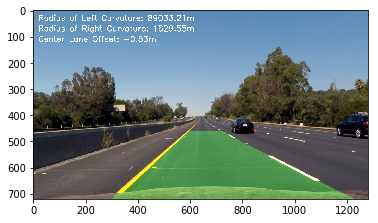

In [141]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

I had to spend some time to figure out the thresold for the gradient transformation and the src,dest functions for perspective transform. The test case worked only upon fine tuning these.

The pipeline doesnt perform very well in the challenge test case. I think the transform to keep the lane markings from previous stage for radius/offset under a certain threshold is not a very reliable mechanism. The pipeline needs to be fixed to be more accurate, I guess more time needs to be invested in thresholding and gradient part of the pipeline to fix this.

The pipeline wouldnt work well if the car deviates from the center of lane or does a lane change
